Post process 3D bbx tracking data produced in April 2021
Goals
1. rectify 3D bbox measurements into comprehensible trajecotry data for enhancing training
2. manual validate the rectified measurements with the videos

Tasks
1. compute homography matrix (done)
2. transform bottom 4 poitns into real-world coords (done)
3. work on the road plane (done)
4. use optimization to rectify measurements (done)
5. add motion (velocity. acceleration) constraints in optimization (done)
6. optimization switch direction south/north bound
6. Apply Joint Probabilistic Data Association algorithm (JPDA)
    https://stonesoup.readthedocs.io/en/latest/auto_tutorials/08_JPDATutorial.html
    a. one object has 4 measurements

In [65]:
from utils import *
import importlib
import utils
importlib.reload(utils)
import os.path
from os import path
import pandas as pd
import utils_optimization as opt
importlib.reload(opt)
import time
from scipy.optimize import minimize,NonlinearConstraint,leastsq,fmin_slsqp,least_squares
import numpy.linalg as LA

In [127]:
data_path = pathlib.Path().absolute().joinpath('../2D-3D May 2021')
file_name = data_path.joinpath('record_p2c1_00001_track_outputs_corrected_3D.csv')
df = utils.read_data(file_name,0)

path_vpts = data_path.joinpath('camera_calibration_points_I24_validation_system.csv')
print('Transform from image to gps...')
df = utils.img_to_gps(df, 'P2C1', path_vpts) # P1C4 good
A = [36.004654, -86.609976] # south west side, so that x, y coords obey counterclockwise
B = [36.002114, -86.607129]
print('Transform from gps to road...')
df = utils.gps_to_road_df(df,A,B)
print('Get x direction...')
df = utils.get_x_direction(df)
print('Naive filter...')
df = utils.naive_filter_3D(df)
df = df[df['direction']<0]
xmin,xmax,ymin,ymax = utils.get_xy_minmax(df)
df

Transform from image to gps...
Transform from gps to road...


C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:68: RuntimeWarning: invalid value encountered in cos
  


Get x direction...
Naive filter...


C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:177: RuntimeWarning: invalid value encountered in greater
  # filter outlier based on length
C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:185: RuntimeWarning: invalid value encountered in greater
  isnan = np.isnan(np.sum(Y,axis=-1))
C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:183: RuntimeWarning: Mean of empty slice
  Y[outliers,:] = np.nan
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Frame #     Timestamp      ID Object class    BBox xmin    BBox ymin  \
0            0  1.758018e+09     211        sedan  2265.275146   805.749146   
1            1  1.758018e+09     211        sedan  2251.044678   788.480042   
2            2  1.758018e+09     211        sedan  2233.026367   771.221313   
3            3  1.758018e+09     211        sedan  2218.193359   755.491516   
4            4  1.758018e+09     211        sedan  2197.824951   741.702942   
...        ...           ...     ...          ...          ...          ...   
15132     1999  1.758018e+09  203261       pickup  1451.176025   172.289322   
15133     2000  1.758018e+09  203261       pickup  1447.153809   168.303528   
15512     1998  1.758018e+09  212261       pickup  3318.664307  1647.084595   
15513     1999  1.758018e+09  212261       pickup  3270.604248  1626.888428   
15514     2000  1.758018e+09  212261       pickup  3212.317139  1589.609009   

         BBox xmax    BBox ymax      vel_x      vel_y  ...     bbllon  \
0      2389.304932   903.412842   0.000000   0.000000  ... -86.608253   
1      2373.555420   887.342529 -14.188906 -17.225513  ... -86.608261   
2      2354.667725   869.898987 -16.613955 -17.245939  ... -86.608270   
3      2337.128662   853.020813 -15.671129 -16.715082  ... -86.608278   
4      2316.750977   836.944702 -18.531031 -15.868293  ... -86.608286   
...            ...          ...        ...        ...  ...        ...   
15132  1497.884766   213.632782  -4.287033  -4.084016  ... -86.608974   
15133  1493.654297   209.286697  -4.067643  -4.066585  ... -86.608982   
15512  3726.442627  2003.747681   0.000000   0.000000  ... -86.607955   
15513  3676.661865  1950.315552 -47.922173 -20.123367  ... -86.607963   
15514  3608.225586  1886.520752 -55.164856 -28.806116  ... -86.607972   

            bbr_x      bbr_y       fbr_x      fbr_y       fbl_x      fbl_y  \
0      194.417610  32.970796  190.728597  33.144191  191.015720  31.377343   
1      193.268819  32.990702  189.389781  33.249308  189.484927  31.555534   
2      192.123618  33.001646  188.317953  33.258803  188.419508  31.536688   
3      190.953021  33.057643  187.069010  33.369995  187.072727  31.615598   
4      189.826412  33.040855  186.032494  33.363815  186.061609  31.595749   
...           ...        ...         ...        ...         ...        ...   
15132   99.342636  31.633989   90.221891  31.865437   90.848724  28.469748   
15133   98.215788  31.674177   88.875173  31.898637   89.549705  28.489478   
15512  234.946535  32.319654  229.310351  32.554770  229.605874  30.879230   
15513  233.928254  32.257725  228.273099  32.510850  228.530949  30.893415   
15514  232.400924  32.665771  226.988059  32.794733  227.432901  30.931255   

            bbl_x      bbl_y  direction  
0      194.928871  31.408825       -1.0  
1      193.730896  31.589784       -1.0  
2      192.596921  31.570371       -1.0  
3      191.420545  31.650724       -1.0  
4      190.296527  31.630154       -1.0  
...           ...        ...        ...  
15132  100.653577  28.544248       -1.0  
15133   99.538664  28.565393       -1.0  
15512  235.351907  30.925304       -1.0  
15513  234.313587  30.939788       -1.0  
15514  232.893211  30.975062       -1.0  

[8155 rows x 46 columns]

In [72]:
import utils
importlib.reload(utils)
AB = np.array([A,B])
lats = AB[:,0]
lngs = AB[:,1]
Y1gps = np.array(df[['bbrlat','bbrlon','fbrlat','fbrlon','fbllat','fbllon','bbllat','bbllon']])[:10,:]
Y2gps = np.array(Y1re[['bbrlat','bbrlon','fbrlat','fbrlon','fbllat','fbllon','bbllat','bbllon']])[-200:-150,:]
Ygps = np.vstack([Y1gps,Y2gps])
# Y_test = utils.gps_to_road(Y1gps,A,B)
# Ygps_test = utils.road_to_gps(Y1,A,B)

utils.draw_map_box(Ygps, 30, lats,lngs)


###############################

 Beginning Key Insertion ...

Key Insertion Completed!!


C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:230: ResourceWarning: unclosed file <_io.TextIOWrapper name='test.html' mode='r' encoding='cp1252'>
  open(fname, 'w').write(newtxt)
C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:234: ResourceWarning: unclosed file <_io.TextIOWrapper name='test.html' mode='w' encoding='cp1252'>
  def jupyter_display(gmplot_filename):


In [73]:
Ygps = np.array(df[['bbrlat','bbrlon','fbrlat','fbrlon','fbllat','fbllon','bbllat','bbllon']])
Y = np.array(df[['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
print(np.count_nonzero(~np.isnan(np.sum(Ygps,axis=-1))))
print(np.count_nonzero(~np.isnan(np.sum(Y,axis=-1))))

7801
7801


63  unique cars
ID: 211


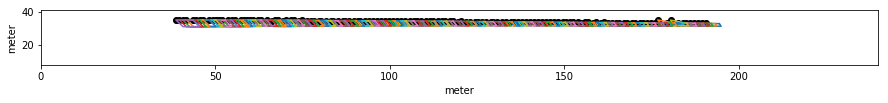

ID: 261


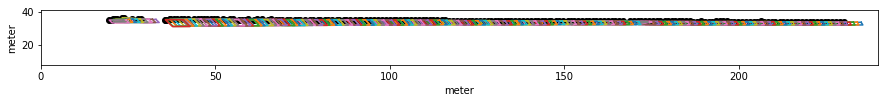

ID: 1211


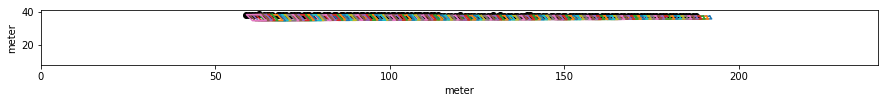

ID: 2221


KeyboardInterrupt: 

In [128]:
# plot original
# group by objects

groups = df.groupby('ID')
groupList = list(groups.groups)
nO = len(groupList) # number of cars to test
print(nO,' unique cars')

for i in range(nO):
    ID = groupList[i]
#     ID = 100261
    Y1 = groups.get_group(ID)

    # get bottom 4 points coordinates
    Y1gps = np.array(Y1[['bbrlat','bbrlon','fbrlat','fbrlon','fbllat','fbllon','bbllat','bbllon']])
    Y1 = np.array(Y1[['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])

    # plot 
    print('ID:',ID)
    D = Y1
    fig, ax = plt.subplots(figsize=(15,1))

    for i in range(len(D)):
        coord = D[i,:]
        coord = np.reshape(coord,(-1,2)).tolist()
        coord.append(coord[0]) #repeat the first point to create a 'closed loop'
        xs, ys = zip(*coord) #lon, lat as x, y
        plt.plot(xs,ys)
    plt.scatter(D[:,2],D[:,3],color='black') # fbr
    ax = plt.gca()
    plt.xlabel('meter')
    plt.ylabel('meter')
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    ax.format_coord = lambda x,y: '%.6f, %.6f' % (x,y)
    plt.show() 


73 unique cars
ID: 22261 Valid/total timestamps: 119 / 51 score: 1.573373030345485 runtime: 1.7426481246948242 
 width: 1.855302305157626 length: 4.2582315606482695


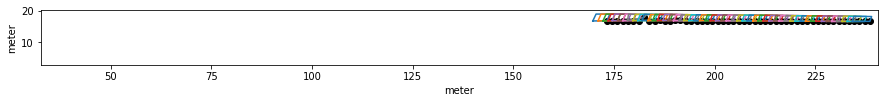

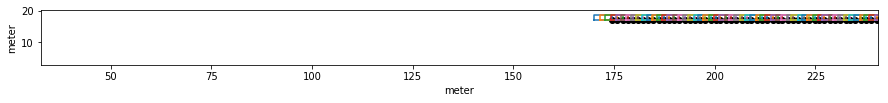

ID: 24261 Valid/total timestamps: 142 / 52 score: 0.10516391790702534 runtime: 5.111729621887207 
 width: 1.9961090841814693 length: 4.1362502652682345


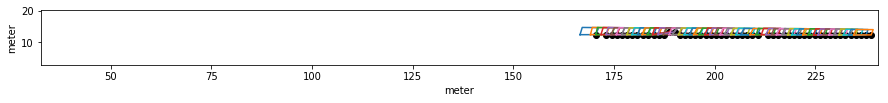

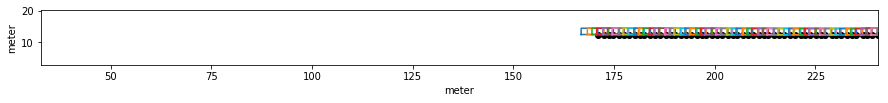

ID: 30261 Valid/total timestamps: 66 / 66 score: 0.17994508036569914 runtime: 0.6319575309753418 
 width: 2.170985862081438 length: 2.923257857475836


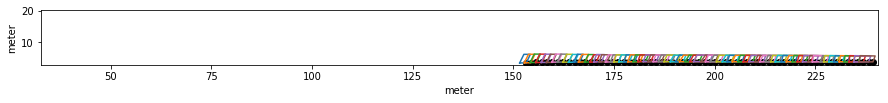

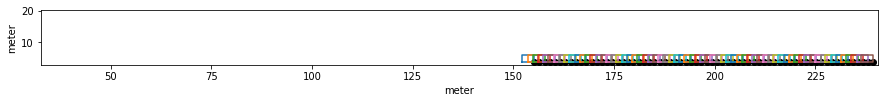

ID: 37261 Valid/total timestamps: 116 / 91 score: 0.1070224277359261 runtime: 4.941472053527832 
 width: 2.076333043572169 length: 3.81738921446181


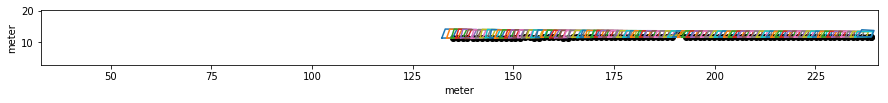

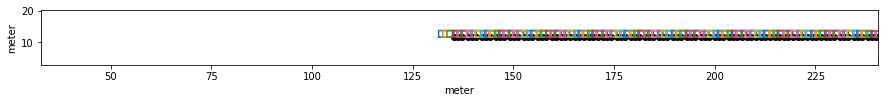

ID: 39261 Valid/total timestamps: 113 / 70 score: 2.182531821269367 runtime: 1.748654842376709 
 width: 2.0795028780831037 length: 4.19010920357351


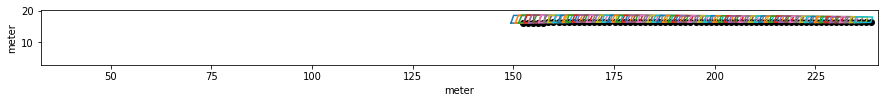

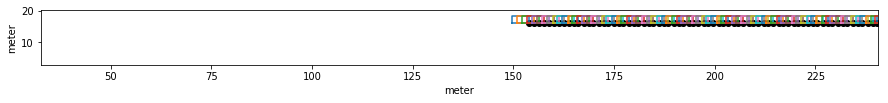

ID: 49261 Valid/total timestamps: 143 / 81 score: 0.11409576917341763 runtime: 5.459257125854492 
 width: 2.050778553484032 length: 3.208657733455257


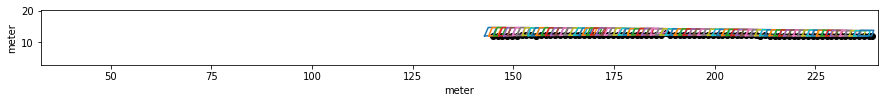

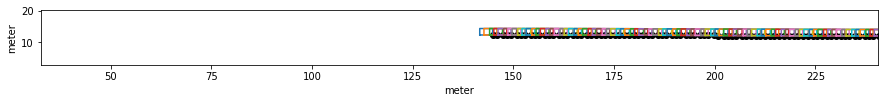

ID: 56261 Valid/total timestamps: 100 / 71 score: 0.2586114265771127 runtime: 1.6024374961853027 
 width: 2.0738968257507016 length: 3.986000254161072


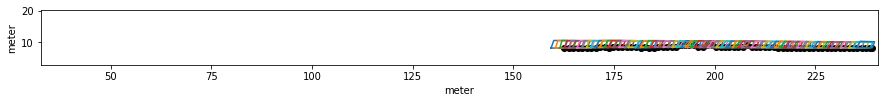

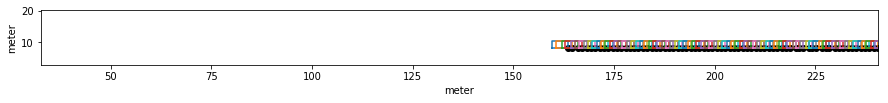

ID: 63261 Valid/total timestamps: 142 / 91 score: 0.1261641206480271 runtime: 5.54638409614563 
 width: 2.198544676359657 length: 3.2123961202136724


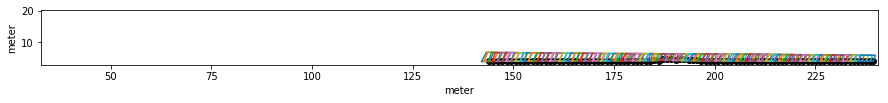

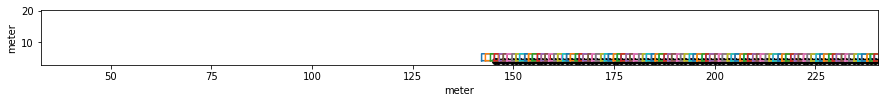

ID: 69261 Valid/total timestamps: 130 / 81 score: 0.12018602387004032 runtime: 5.045642375946045 
 width: 2.203242461770691 length: 4.427675733314485


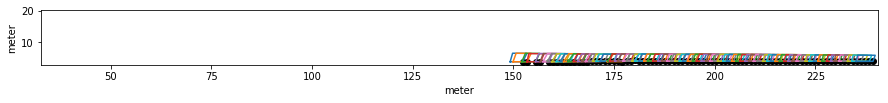

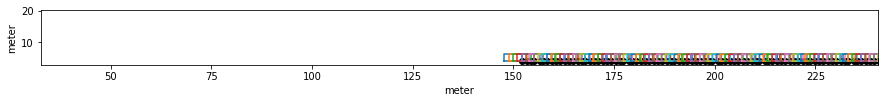

ID: 70261 Valid/total timestamps: 135 / 77 score: 0.11788622868398482 runtime: 6.1853532791137695 
 width: 1.9892482900674988 length: 3.631004750457374


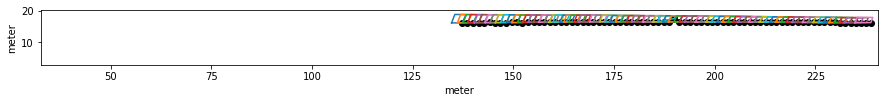

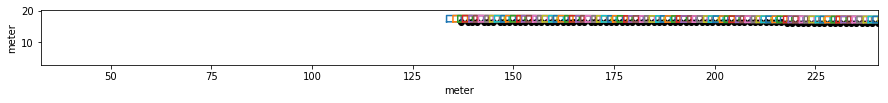

ID: 73261 Valid/total timestamps: 153 / 82 score: 0.09889421027223612 runtime: 5.758707523345947 
 width: 2.2450563140857493 length: 4.483754925139864


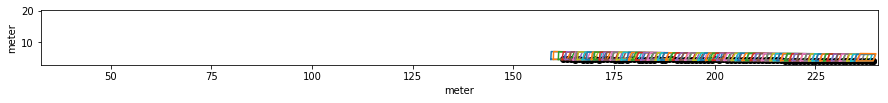

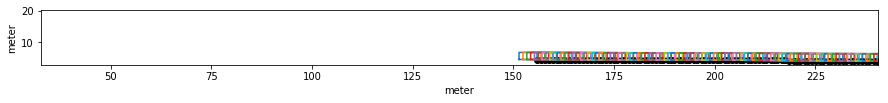

ID: 76261 Valid/total timestamps: 170 / 149 score: 0.35213937555334535 runtime: 6.204376459121704 
 width: 3.1323105433684906 length: 18.263262677734634


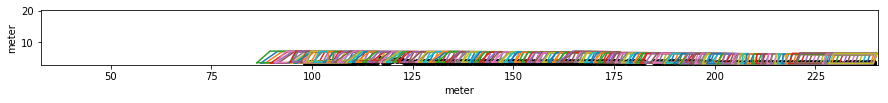

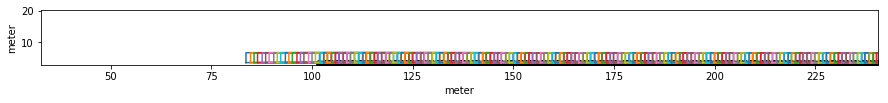

ID: 78261 Valid/total timestamps: 157 / 96 score: 0.13689552791208964 runtime: 2.2754435539245605 
 width: 2.2070957374952322 length: 3.443623628076701


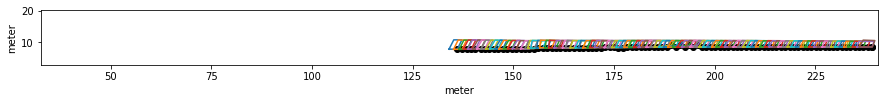

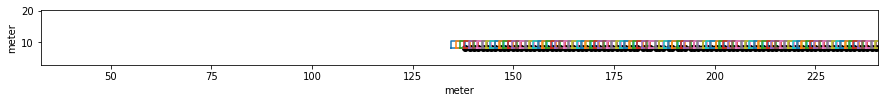

ID: 80261 Valid/total timestamps: 148 / 81 score: 0.2602962409212504 runtime: 2.1422393321990967 
 width: 1.9912269001086116 length: 3.1635404177958675


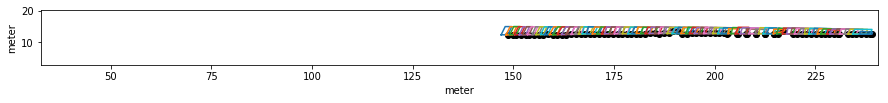

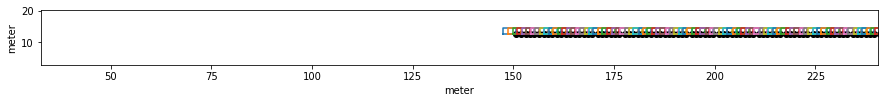

ID: 83261 Valid/total timestamps: 84 / 81 score: 0.23735781281007884 runtime: 1.2178401947021484 
 width: 2.096293352869825 length: 3.6969680258853526


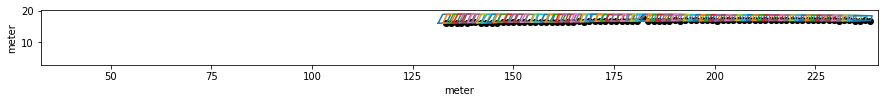

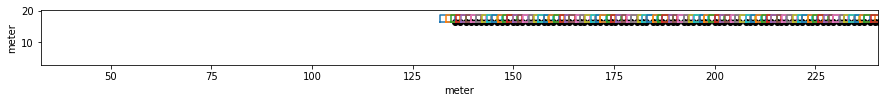

ID: 86261 Valid/total timestamps: 192 / 171 score: 0.3929515978450557 runtime: 3.9219443798065186 
 width: 3.991303595881424 length: 20.61431840212134


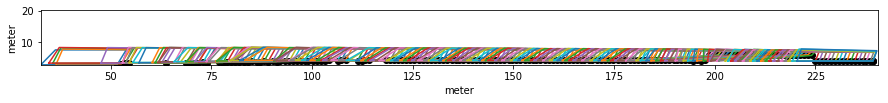

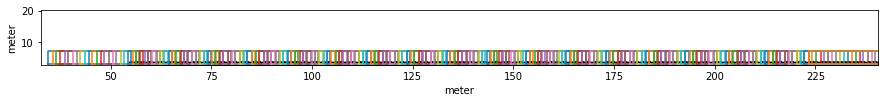

ID: 87261 Valid/total timestamps: 86 / 17 score: 36.37321147492437 runtime: 1.1747772693634033 
 width: 1.9968313387945429 length: 4.288621177346551


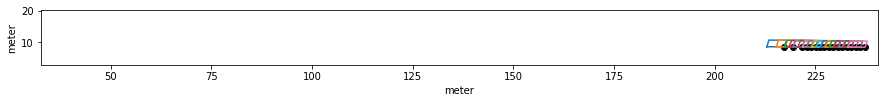

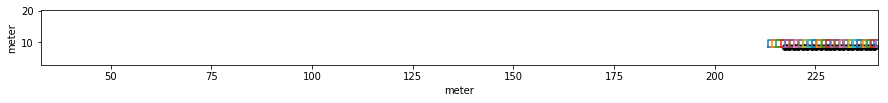

ID: 89261 Valid/total timestamps: 160 / 157 score: 0.26626971586938075 runtime: 2.9654862880706787 
 width: 3.132780704055305 length: 11.98044112185437


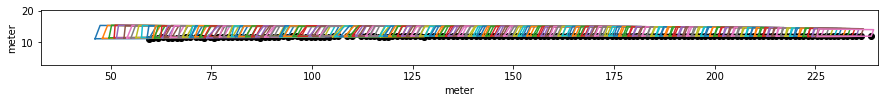

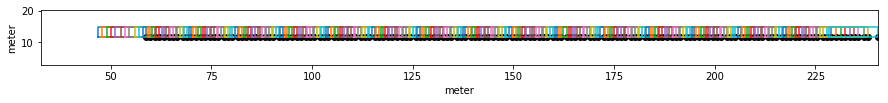

ID: 93261 Valid/total timestamps: 162 / 93 score: 0.2407953294692899 runtime: 3.1557741165161133 
 width: 2.4802788690549256 length: 4.727625231981044


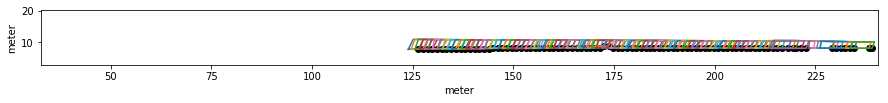

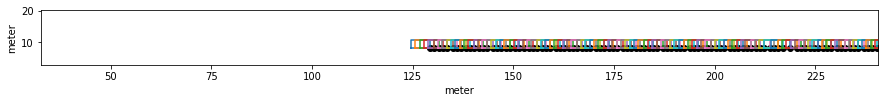

ID: 96261 Valid/total timestamps: 72 / 66 score: 0.3489442844666292 runtime: 0.625960111618042 
 width: 2.3349739153307603 length: 2.197409082506905


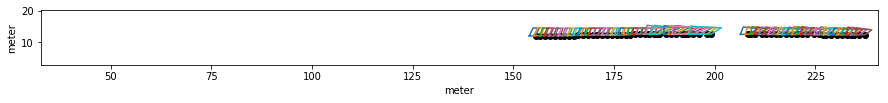

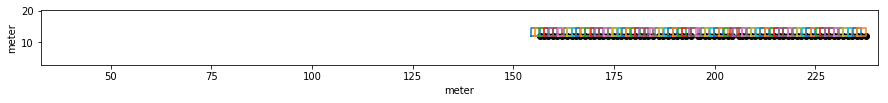

ID: 98261 Valid/total timestamps: 127 / 70 score: 0.24678313415856365 runtime: 2.0490970611572266 
 width: 2.1604870726754526 length: 3.9337101290351093


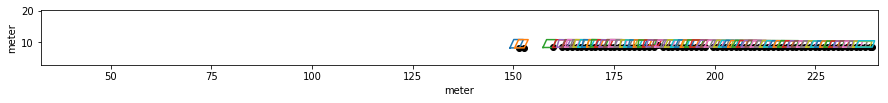

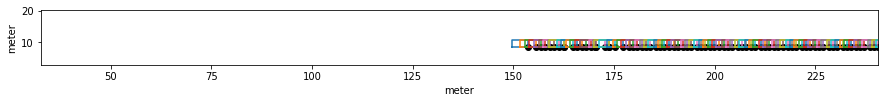

ID: 100261 Valid/total timestamps: 79 / 66 score: 0.23889357265160993 runtime: 4.1482720375061035 
 width: 2.277629734780369 length: 4.166031991158735


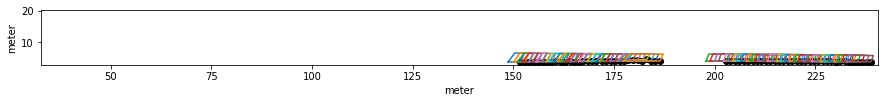

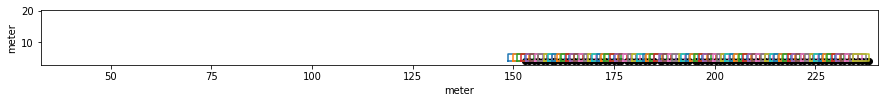

ID: 102261 Valid/total timestamps: 138 / 62 score: 1.4030620944659464 runtime: 2.1262168884277344 
 width: 2.1128417301687543 length: 4.946830348775129


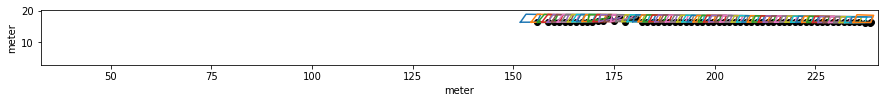

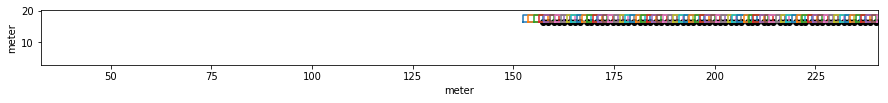

ID: 105261 Valid/total timestamps: 119 / 70 score: 0.5235064144255347 runtime: 2.0273191928863525 
 width: 2.002537333707382 length: 3.9369625598444924


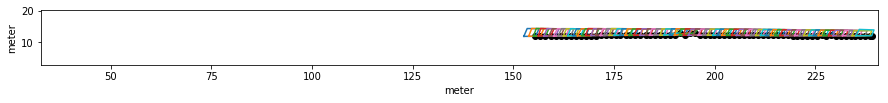

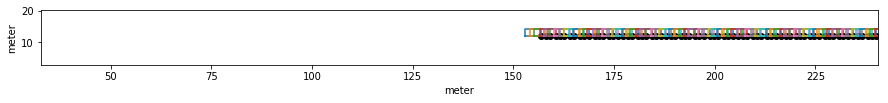

ID: 109261 Valid/total timestamps: 134 / 91 score: 0.20245222896796417 runtime: 6.041149377822876 
 width: 2.282773029126575 length: 3.3337779801299403


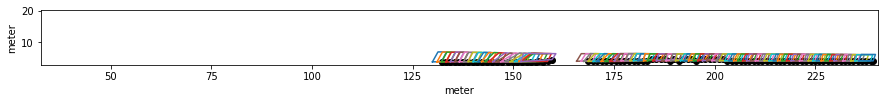

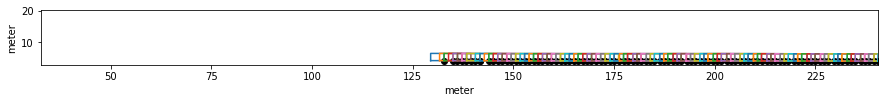

KeyboardInterrupt: 

In [28]:
import utils_optimization as opt
importlib.reload(opt)
# group by objects

groups = df.groupby('ID')
groupList = list(groups.groups)
nO = len(groupList) # number of cars to test
print(nO,'unique cars')
# optimization parameters
lam1 = 1 # modification of measurement
lam2 = 1 # acceleration
lam3 = 0 # jerk
lam4 = 10 # theta
lam5 = 1 # omega

score = np.zeros(nO) # record correction score

for i in range(nO):
    ID = groupList[i]
    Y1 = groups.get_group(ID)
    
    # impute missing timestamps
    timestamps = Y1['Timestamp'].values
    timestamps= utils.nan_helper(timestamps)
    dt = np.diff(timestamps)

    # get bottom 4 points coordinates
    Y1gps = np.array(Y1[['bbrlat','bbrlon','fbrlat','fbrlon','fbllat','fbllon','bbllat','bbllon']])
    Y1 = np.array(Y1[['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
    
    if len(Y1)<2:
        continue
        
    # Euler forward dynamics
    start = time.time()
    N = len(Y1) 
    notNan = ~np.isnan(np.sum(Y1,axis=-1))
    Y1 = Y1[notNan,:]
    a0 = np.zeros((N))
    theta0 = np.zeros((N))
    v0 = (Y1[-1,0]-Y1[0,0])/(timestamps[notNan][-1]-timestamps[notNan][0])
    x0 = (Y1[0,0]+Y1[0,6])/2
    y0 = (Y1[0,1]+Y1[0,7])/2
    X0 = np.concatenate((a0.T, theta0.T, \
                         [v0,x0,y0,np.nanmean(np.abs(Y1[:,1]-Y1[:,7])),\
                          np.nanmean(np.abs(Y1[:,0]-Y1[:,2]))]),axis=-1)
    bnds = [(-5,5) for i in range(0,N)]+\
        [(-np.pi/8,np.pi/8) for i in range(N)]+\
        [(0,40),(-np.inf,np.inf),(0,np.inf),(1,4),(2,np.inf)]

    # Constraints definition (only for COBYLA, SLSQP and trust-constr)
    res = minimize(opt.obj1, X0, (Y1,N,dt,notNan,lam1,lam2,lam3,lam4,lam5), method = 'L-BFGS-B',
                    bounds=bnds, options={'disp': False,'maxiter':100000})#
    end = time.time()
    # extract results
    Yre, x,y,v,a,theta,omega,w,l = opt.unpack1(res,N,dt)
    score[i] = LA.norm(Y1-Yre[notNan,:],'fro')/np.count_nonzero(notNan)
    print('ID:',ID, 'Valid/total timestamps:',N, '/',np.count_nonzero(notNan),'score:',score[i],\
          'runtime:',end - start,'\n width:',w,'length:',l) 
    # plot 
    D = Y1
    fig, ax = plt.subplots(figsize=(15,1))

    for i in range(len(D)):
        coord = D[i,:]
        coord = np.reshape(coord,(-1,2)).tolist()
        coord.append(coord[0]) #repeat the first point to create a 'closed loop'
        xs, ys = zip(*coord) #lon, lat as x, y
        plt.plot(xs,ys)
    plt.scatter(D[:,2],D[:,3],color='black')
    ax = plt.gca()
    plt.xlabel('meter')
    plt.ylabel('meter')
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    ax.format_coord = lambda x,y: '%.6f, %.6f' % (x,y)
    plt.show() 

    D = Yre
    fig, ax = plt.subplots(figsize=(15,1))
    for i in range(len(D)):
        coord = D[i,:]
        coord = np.reshape(coord,(-1,2)).tolist()
        coord.append(coord[0]) #repeat the first point to create a 'closed loop'
        xs, ys = zip(*coord) #lon, lat as x, y
        plt.plot(xs,ys)
    plt.scatter(D[:,2],D[:,3],color='black')
    ax = plt.gca()
    plt.xlabel('meter')
    plt.ylabel('meter')
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    ax.format_coord = lambda x,y: '%.6f, %.6f' % (x,y)
    plt.show() 

In [160]:
import utils_optimization as opt
importlib.reload(opt)
# group by objects

groups = df.groupby('ID')
groupList = list(groups.groups)
nO = len(groupList) # number of cars to test
print(nO,'unique cars')

ID = groupList[0]
Y1 = groups.get_group(ID)

Y1re = opt.rectify_single_camera(Y1)
Y1re
    

63 unique cars
[3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.

 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265]
[3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14

 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265]
[3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14

 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265]
[3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159266 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14

 3.14159265 3.14159265 3.14159265 3.14159265 3.14159266]
[3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265
 3.14

[3.0191982  3.04812564 3.04827015 3.01942296 3.04853283 3.04874732
 3.02032406 3.04906436 3.04879235 3.02202825 3.05081323 3.05062502
 3.02399108 3.05199064 3.05233636 3.02508332 3.05285444 3.05313572
 3.02620309 3.05377015 3.05407422 3.02747487 3.05466268 3.05500907
 3.0287427  3.05567836 3.05593619 3.030122   3.05670878 3.05707839
 3.03163403 3.05791639 3.05834862 3.03318657 3.0589004  3.05947798
 3.03483108 3.06034849 3.03595476 3.06112435 3.06158465 3.03760832
 3.06253913 3.0630037  3.03974919 3.06411689 3.06456822 3.04189103
 3.06571828 3.06626065 3.04403043 3.06721468 3.06785106 3.04632291
 3.0690418  3.0697066  3.0487777  3.07096839 3.07158843 3.05147292
 3.07291461 3.07353749 3.05403767 3.07502732 3.07561179 3.05695098
 3.07712258 3.07794064 3.06002372 3.07942181 3.08022605 3.06303518
 3.08167565 3.08242438 3.06607124 3.08404575 3.08470696 3.06922512
 3.08645685 3.08722934 3.07249948 3.08894592 3.0897634  3.07597212
 3.09148882 3.0923536  3.07950316 3.09417121 3.09518182 3.0829

 3.13344806 3.13397319 3.13510971 3.13526412 3.13526412]
[3.0191982  3.04812564 3.04827015 3.01942296 3.04853283 3.04874732
 3.02032406 3.04906436 3.04879235 3.02202825 3.05081323 3.05062502
 3.02399108 3.05199064 3.05233636 3.02508332 3.05285445 3.05313572
 3.02620309 3.05377015 3.05407422 3.02747487 3.05466268 3.05500907
 3.0287427  3.05567836 3.05593619 3.030122   3.05670878 3.05707839
 3.03163403 3.05791639 3.05834862 3.03318657 3.0589004  3.05947798
 3.03483108 3.06034849 3.03595476 3.06112435 3.06158465 3.03760832
 3.06253913 3.0630037  3.03974919 3.06411689 3.06456822 3.04189103
 3.06571828 3.06626065 3.04403043 3.06721468 3.06785106 3.04632291
 3.0690418  3.0697066  3.0487777  3.07096839 3.07158843 3.05147292
 3.07291461 3.07353749 3.05403767 3.07502732 3.07561179 3.05695098
 3.07712258 3.07794064 3.06002372 3.07942181 3.08022605 3.06303518
 3.08167565 3.08242438 3.06607124 3.08404575 3.08470696 3.06922512
 3.08645685 3.08722934 3.07249948 3.08894592 3.0897634  3.07597212
 3.09

 3.13344806 3.13397319 3.13510971 3.13526412 3.13526412]
[3.0191982  3.04812564 3.04827015 3.01942296 3.04853283 3.04874732
 3.02032406 3.04906436 3.04879235 3.02202825 3.05081323 3.05062502
 3.02399108 3.05199064 3.05233636 3.02508332 3.05285444 3.05313572
 3.02620309 3.05377015 3.05407422 3.02747487 3.05466268 3.05500907
 3.0287427  3.05567836 3.05593619 3.030122   3.05670878 3.05707839
 3.03163403 3.05791639 3.05834862 3.03318657 3.0589004  3.05947798
 3.03483108 3.06034849 3.03595476 3.06112435 3.06158465 3.03760832
 3.06253913 3.0630037  3.03974919 3.06411689 3.06456822 3.04189103
 3.06571828 3.06626065 3.04403043 3.06721468 3.06785106 3.04632291
 3.0690418  3.0697066  3.0487777  3.07096839 3.07158843 3.05147292
 3.07291461 3.07353749 3.05403767 3.07502732 3.07561179 3.05695098
 3.07712258 3.07794064 3.06002372 3.07942181 3.08022605 3.06303518
 3.08167565 3.08242438 3.06607124 3.08404575 3.08470696 3.06922512
 3.08645685 3.08722934 3.07249948 3.08894592 3.0897634  3.07597212
 3.09

 3.14034665 3.14042698 3.14060086 3.14062448 3.14062448]
[3.12286805 3.12729353 3.12731564 3.12290243 3.12735583 3.12738864
 3.12304029 3.12743714 3.12739553 3.123301   3.1277047  3.1276759
 3.12360129 3.12788482 3.12793771 3.12376839 3.12801697 3.12806
 3.1239397  3.12815706 3.12820358 3.12413426 3.12829361 3.1283466
 3.12432822 3.12844899 3.12848844 3.12453923 3.12860663 3.12866318
 3.12477055 3.12879138 3.1288575  3.12500807 3.12894192 3.12903028
 3.12525965 3.12916345 3.12543156 3.12928215 3.12935257 3.12568453
 3.12949859 3.12956966 3.12601206 3.12973997 3.12980901 3.12633973
 3.12998496 3.13006793 3.12666702 3.13021388 3.13031124 3.12701774
 3.13049341 3.13059511 3.12739329 3.13078815 3.13088301 3.12780562
 3.13108589 3.13118118 3.12819799 3.13140911 3.13149852 3.12864368
 3.13172965 3.1318548  3.12911377 3.1320814  3.13220444 3.12957448
 3.13242621 3.13254075 3.13003895 3.1327888  3.13288995 3.13052145
 3.13315766 3.13327584 3.13102238 3.13353845 3.13366352 3.13155365
 3.1339274

[3.12286805 3.12729353 3.12731564 3.12290243 3.12735583 3.12738864
 3.12304029 3.12743714 3.12739553 3.123301   3.1277047  3.1276759
 3.12360129 3.12788482 3.12793771 3.12376839 3.12801697 3.12806
 3.1239397  3.12815706 3.12820358 3.12413426 3.12829361 3.1283466
 3.12432822 3.12844899 3.12848844 3.12453923 3.12860663 3.12866318
 3.12477055 3.12879138 3.1288575  3.12500807 3.12894192 3.12903028
 3.12525965 3.12916345 3.12543156 3.12928215 3.12935257 3.12568453
 3.12949859 3.12956966 3.12601206 3.12973997 3.12980901 3.12633973
 3.12998496 3.13006793 3.12666702 3.13021388 3.13031124 3.12701774
 3.13049341 3.13059511 3.12739329 3.13078815 3.13088301 3.12780562
 3.13108589 3.13118118 3.12819799 3.13140911 3.13149852 3.12864368
 3.13172965 3.1318548  3.12911377 3.1320814  3.13220444 3.12957448
 3.13242621 3.13254075 3.13003895 3.1327888  3.13288995 3.13052145
 3.13315766 3.13327584 3.13102238 3.13353845 3.13366352 3.13155365
 3.13392748 3.13405978 3.13209385 3.13433785 3.13449246 3.13262701


[3.12286805 3.12729353 3.12731564 3.12290243 3.12735583 3.12738864
 3.12304029 3.12743714 3.12739553 3.123301   3.1277047  3.1276759
 3.12360129 3.12788482 3.12793771 3.12376839 3.12801697 3.12806
 3.1239397  3.12815706 3.12820358 3.12413426 3.12829361 3.1283466
 3.12432822 3.12844899 3.12848844 3.12453923 3.12860663 3.12866318
 3.12477055 3.12879138 3.1288575  3.12500807 3.12894192 3.12903028
 3.12525965 3.12916345 3.12543156 3.12928215 3.12935258 3.12568453
 3.12949859 3.12956966 3.12601206 3.12973997 3.12980901 3.12633973
 3.12998496 3.13006793 3.12666702 3.13021388 3.13031124 3.12701774
 3.13049341 3.13059511 3.12739329 3.13078815 3.13088301 3.12780562
 3.13108589 3.13118118 3.12819799 3.13140911 3.13149852 3.12864368
 3.13172965 3.1318548  3.12911377 3.1320814  3.13220444 3.12957448
 3.13242621 3.13254075 3.13003895 3.1327888  3.13288995 3.13052145
 3.13315766 3.13327584 3.13102238 3.13353845 3.13366352 3.13155365
 3.13392748 3.13405978 3.13209385 3.13433785 3.13449246 3.13262701


 3.14034665 3.14042698 3.14060086 3.14062448 3.14062448]
[3.12286805 3.12729353 3.12731564 3.12290243 3.12735583 3.12738864
 3.12304029 3.12743714 3.12739553 3.123301   3.1277047  3.1276759
 3.12360129 3.12788482 3.12793771 3.12376839 3.12801697 3.12806
 3.1239397  3.12815706 3.12820358 3.12413426 3.12829361 3.1283466
 3.12432822 3.12844899 3.12848844 3.12453923 3.12860663 3.12866318
 3.12477055 3.12879138 3.1288575  3.12500807 3.12894192 3.12903028
 3.12525965 3.12916345 3.12543156 3.12928215 3.12935257 3.12568453
 3.12949859 3.12956966 3.12601206 3.12973997 3.12980901 3.12633973
 3.12998496 3.13006793 3.12666702 3.13021388 3.13031124 3.12701774
 3.13049341 3.13059511 3.12739329 3.13078815 3.13088301 3.12780562
 3.13108589 3.13118118 3.12819799 3.13140911 3.13149852 3.12864368
 3.13172965 3.1318548  3.12911377 3.1320814  3.13220444 3.12957448
 3.13242621 3.13254075 3.13003895 3.1327888  3.13288995 3.13052145
 3.13315766 3.13327584 3.13102238 3.13353845 3.13366352 3.13155365
 3.1339274

 3.1400832  3.14012601 3.14023364 3.14005841 3.14005841]
[3.12640947 3.1297563  3.12978833 3.1264447  3.12984099 3.12988617
 3.12663255 3.12994301 3.12985916 3.12700636 3.13034261 3.13027623
 3.1274284  3.13058159 3.13064569 3.1276074  3.13072544 3.13076842
 3.12777502 3.13086868 3.13091318 3.12796263 3.13099225 3.13104262
 3.12813143 3.13113323 3.1311567  3.12830981 3.13126471 3.13131202
 3.12850492 3.13142797 3.1314873  3.12869226 3.13152116 3.13161306
 3.12888666 3.13172014 3.12901359 3.13179722 3.13185208 3.12918121
 3.13196618 3.13201765 3.12945647 3.13216403 3.13220827 3.12971536
 3.13235595 3.13241941 3.12995813 3.13250916 3.13259277 3.13022399
 3.13273512 3.13282201 3.1305162  3.1329758  3.13304773 3.13085608
 3.13321043 3.13327963 3.13114821 3.13347712 3.13353279 3.13151526
 3.13372895 3.13384125 3.1319103  3.13402339 3.13412897 3.13227705
 3.13429666 3.13438461 3.13263747 3.13459015 3.134653   3.1330164
 3.1348855  3.13497382 3.13341445 3.13519232 3.13528959 3.13385324
 3.135

[3.12640947 3.1297563  3.12978834 3.1264447  3.12984099 3.12988617
 3.12663255 3.12994301 3.12985916 3.12700636 3.13034261 3.13027623
 3.1274284  3.13058159 3.13064569 3.1276074  3.13072544 3.13076842
 3.12777502 3.13086868 3.13091318 3.12796263 3.13099225 3.13104262
 3.12813143 3.13113323 3.1311567  3.12830981 3.13126471 3.13131202
 3.12850492 3.13142797 3.1314873  3.12869226 3.13152116 3.13161306
 3.12888666 3.13172014 3.12901359 3.13179722 3.13185208 3.12918121
 3.13196618 3.13201765 3.12945647 3.13216403 3.13220827 3.12971536
 3.13235595 3.13241941 3.12995813 3.13250916 3.13259277 3.13022399
 3.13273512 3.13282201 3.1305162  3.1329758  3.13304773 3.13085608
 3.13321043 3.13327963 3.13114821 3.13347712 3.13353279 3.13151526
 3.13372895 3.13384125 3.1319103  3.13402339 3.13412897 3.13227705
 3.13429666 3.13438461 3.13263747 3.13459015 3.134653   3.1330164
 3.1348855  3.13497382 3.13341445 3.13519232 3.13528959 3.13385324
 3.13550507 3.13561198 3.13429677 3.13584618 3.13598807 3.13471

[3.12640947 3.1297563  3.12978833 3.1264447  3.12984099 3.12988617
 3.12663255 3.12994301 3.12985916 3.12700636 3.13034261 3.13027623
 3.1274284  3.13058159 3.13064569 3.1276074  3.13072544 3.13076842
 3.12777502 3.13086868 3.13091318 3.12796263 3.13099225 3.13104262
 3.12813143 3.13113323 3.1311567  3.12830981 3.13126471 3.13131202
 3.12850492 3.13142797 3.1314873  3.12869226 3.13152116 3.13161306
 3.12888666 3.13172014 3.12901359 3.13179722 3.13185208 3.12918121
 3.13196618 3.13201765 3.12945647 3.13216403 3.13220827 3.12971536
 3.13235595 3.13241941 3.12995813 3.13250916 3.13259277 3.13022399
 3.13273512 3.13282201 3.1305162  3.1329758  3.13304773 3.13085608
 3.13321043 3.13327963 3.13114821 3.13347712 3.13353279 3.13151526
 3.13372895 3.13384125 3.1319103  3.13402339 3.13412897 3.13227705
 3.13429666 3.13438461 3.13263747 3.13459015 3.134653   3.1330164
 3.1348855  3.13497382 3.13341445 3.13519232 3.13528959 3.13385324
 3.13550507 3.13561198 3.13429677 3.13584618 3.13598807 3.13471

 3.13873932 3.13869626 3.13866767 3.13783854 3.13783854]
[3.12904768 3.13101138 3.13108702 3.12910181 3.13120006 3.13130188
 3.12952063 3.13140898 3.1311637  3.13039327 3.13237507 3.13216884
 3.13136187 3.13289497 3.13302131 3.1316588  3.13313979 3.13320303
 3.13189516 3.1333599  3.13341979 3.13215231 3.13350529 3.1335723
 3.1323304  3.13367292 3.13366213 3.13250228 3.13379334 3.13383736
 3.13268931 3.13397476 3.13404364 3.1328259  3.13395062 3.13409747
 3.13295359 3.13418298 3.13301576 3.13418006 3.13421783 3.13302472
 3.1342977  3.13431909 3.13328808 3.13446991 3.13446588 3.13348073
 3.13460652 3.13464628 3.13360521 3.13462163 3.13470778 3.13376347
 3.13480806 3.13489617 3.13396552 3.13501527 3.13505814 3.13426975
 3.13518808 3.13521794 3.13442439 3.13542753 3.13541558 3.13475217
 3.1356104  3.13574228 3.13513215 3.13588951 3.13599831 3.13541672
 3.13609687 3.13615363 3.1356636  3.1363416  3.13632771 3.1359397
 3.13657681 3.13662493 3.13624665 3.136828   3.13689546 3.13664415
 3.1370

 3.13873932 3.13869626 3.13866767 3.13783854 3.13783854]
[3.12904768 3.13101138 3.13108702 3.12910181 3.13120006 3.13130188
 3.12952063 3.13140898 3.1311637  3.13039327 3.13237507 3.13216884
 3.13136187 3.13289497 3.13302131 3.1316588  3.13313979 3.13320303
 3.13189516 3.1333599  3.13341979 3.13215231 3.13350529 3.1335723
 3.1323304  3.13367292 3.13366213 3.13250228 3.13379334 3.13383736
 3.13268931 3.13397476 3.13404364 3.1328259  3.13395062 3.13409747
 3.13295359 3.13418298 3.13301576 3.13418006 3.13421783 3.13302472
 3.1342977  3.13431909 3.13328808 3.13446991 3.13446588 3.13348073
 3.13460652 3.13464628 3.13360521 3.13462163 3.13470778 3.13376347
 3.13480806 3.13489617 3.13396552 3.13501527 3.13505814 3.13426975
 3.13518808 3.13521794 3.13442439 3.13542753 3.13541558 3.13475217
 3.1356104  3.13574228 3.13513215 3.13588951 3.13599831 3.13541672
 3.13609687 3.13615363 3.1356636  3.1363416  3.13632771 3.1359397
 3.13657681 3.13662493 3.13624665 3.136828   3.13689546 3.13664415
 3.1370

[3.12904768 3.13101138 3.13108702 3.12910181 3.13120006 3.13130188
 3.12952063 3.13140898 3.1311637  3.13039327 3.13237507 3.13216884
 3.13136187 3.13289497 3.13302131 3.1316588  3.13313979 3.13320303
 3.13189516 3.1333599  3.13341979 3.13215231 3.13350529 3.1335723
 3.1323304  3.13367292 3.13366213 3.13250228 3.13379334 3.13383736
 3.13268931 3.13397476 3.13404364 3.1328259  3.13395062 3.13409747
 3.13295359 3.13418298 3.13301576 3.13418006 3.13421783 3.13302473
 3.1342977  3.13431909 3.13328808 3.13446991 3.13446588 3.13348073
 3.13460652 3.13464628 3.13360521 3.13462163 3.13470778 3.13376347
 3.13480806 3.13489617 3.13396552 3.13501527 3.13505814 3.13426975
 3.13518808 3.13521794 3.13442439 3.13542753 3.13541558 3.13475217
 3.1356104  3.13574228 3.13513215 3.13588951 3.13599831 3.13541672
 3.13609687 3.13615363 3.1356636  3.1363416  3.13632771 3.1359397
 3.13657681 3.13662493 3.13624665 3.136828   3.13689546 3.13664415
 3.1370818  3.13717049 3.13703718 3.13739804 3.1375751  3.137357

 3.13873932 3.13869626 3.13866767 3.13783854 3.13783854]
[3.12904768 3.13101138 3.13108702 3.12910181 3.13120006 3.13130188
 3.12952063 3.13140898 3.1311637  3.13039327 3.13237507 3.13216884
 3.13136187 3.13289497 3.13302131 3.1316588  3.13313979 3.13320303
 3.13189516 3.1333599  3.13341979 3.13215231 3.13350529 3.1335723
 3.1323304  3.13367292 3.13366213 3.13250228 3.13379334 3.13383736
 3.13268931 3.13397476 3.13404364 3.1328259  3.13395062 3.13409747
 3.13295359 3.13418298 3.13301576 3.13418006 3.13421783 3.13302472
 3.1342977  3.13431909 3.13328808 3.13446991 3.13446588 3.13348073
 3.13460652 3.13464628 3.13360521 3.13462163 3.13470778 3.13376347
 3.13480806 3.13489617 3.13396552 3.13501527 3.13505814 3.13426975
 3.13518808 3.13521794 3.13442439 3.13542753 3.13541558 3.13475217
 3.1356104  3.13574228 3.13513215 3.13588951 3.13599831 3.13541672
 3.13609687 3.13615363 3.1356636  3.1363416  3.13632771 3.1359397
 3.13657681 3.13662493 3.13624665 3.136828   3.13689546 3.13664415
 3.1370

[3.12697574 3.12841361 3.12855768 3.12706417 3.12876664 3.1289577
 3.12784686 3.12914662 3.12865366 3.12949885 3.13099525 3.13057506
 3.13132547 3.13196132 3.13218946 3.13182845 3.13238058 3.13248242
 3.13220242 3.13274349 3.13283646 3.13260682 3.13295257 3.13305694
 3.13284721 3.13319778 3.13314759 3.13306568 3.13334363 3.13339827
 3.133305   3.13360192 3.13370337 3.13343668 3.13345126 3.13370288
 3.13354251 3.13379634 3.13356342 3.13371382 3.13374842 3.13342229
 3.1338235  3.1338234  3.13377023 3.13403304 3.13398133 3.13397129
 3.1341669  3.13419889 3.13403087 3.13405617 3.1341769  3.1341477
 3.13427491 3.1343973  3.13434216 3.13452862 3.13456032 3.13472965
 3.13470886 3.13471325 3.13481579 3.13501425 3.1349344  3.13523413
 3.1352027  3.13540371 3.13574816 3.13557537 3.13572953 3.13606877
 3.13580253 3.13585265 3.136309   3.13609829 3.13600817 3.13660076
 3.13637089 3.13640117 3.13694742 3.13667072 3.13673779 3.13746726
 3.13697201 3.13707967 3.13797363 3.13739271 3.13767346 3.138332

 3.13661995 3.13647749 3.13630381 3.13453207 3.13453205]
[3.12697574 3.12841361 3.12855768 3.12706417 3.12876664 3.1289577
 3.12784686 3.12914662 3.12865366 3.12949886 3.13099525 3.13057506
 3.13132547 3.13196132 3.13218946 3.13182845 3.13238058 3.13248242
 3.13220242 3.13274349 3.13283646 3.13260682 3.13295257 3.13305694
 3.13284721 3.13319778 3.13314759 3.13306568 3.13334363 3.13339827
 3.133305   3.13360192 3.13370337 3.13343668 3.13345126 3.13370288
 3.13354251 3.13379634 3.13356342 3.13371382 3.13374842 3.13342229
 3.1338235  3.1338234  3.13377023 3.13403304 3.13398133 3.13397129
 3.1341669  3.13419889 3.13403087 3.13405617 3.1341769  3.1341477
 3.13427491 3.1343973  3.13434216 3.13452862 3.13456032 3.13472965
 3.13470886 3.13471325 3.13481579 3.13501425 3.1349344  3.13523413
 3.1352027  3.13540371 3.13574816 3.13557537 3.13572953 3.13606877
 3.13580253 3.13585265 3.136309   3.13609829 3.13600817 3.13660076
 3.13637089 3.13640117 3.13694742 3.13667072 3.13673779 3.13746726
 3.1369

[3.12697574 3.12841361 3.12855768 3.12706417 3.12876664 3.1289577
 3.12784686 3.12914662 3.12865366 3.12949885 3.13099525 3.13057506
 3.13132547 3.13196132 3.13218946 3.13182845 3.13238058 3.13248242
 3.13220242 3.13274349 3.13283646 3.13260682 3.13295257 3.13305694
 3.13284721 3.13319778 3.13314759 3.13306568 3.13334363 3.13339827
 3.133305   3.13360192 3.13370337 3.13343668 3.13345126 3.13370288
 3.13354251 3.13379634 3.13356342 3.13371382 3.13374842 3.13342229
 3.1338235  3.1338234  3.13377023 3.13403304 3.13398133 3.13397129
 3.1341669  3.13419889 3.13403087 3.13405617 3.1341769  3.1341477
 3.13427491 3.1343973  3.13434216 3.13452862 3.13456032 3.13472965
 3.13470886 3.13471325 3.13481579 3.13501425 3.1349344  3.13523413
 3.1352027  3.13540371 3.13574816 3.13557537 3.13572953 3.13606877
 3.13580253 3.13585265 3.136309   3.13609829 3.13600817 3.13660076
 3.13637089 3.13640117 3.13694742 3.13667073 3.13673779 3.13746726
 3.13697201 3.13707967 3.13797363 3.13739271 3.13767346 3.138332

[3.12236424 3.12351171 3.1237687  3.1224922  3.12412457 3.12445592
 3.12384954 3.12475383 3.12381145 3.1267624  3.12804989 3.12723205
 3.12997425 3.12970953 3.13008898 3.13074229 3.13035756 3.13050317
 3.13126775 3.13089902 3.13102755 3.13184798 3.13115562 3.13130519
 3.13212579 3.13147895 3.13134416 3.13236574 3.13162065 3.13167988
 3.13264602 3.13197122 3.13211795 3.13273218 3.13157043 3.13199425
 3.13277221 3.13208638 3.13271039 3.13185574 3.13188128 3.13229949
 3.13194168 3.13190252 3.13279459 3.13221134 3.13207799 3.13301978
 3.13234321 3.13236436 3.13298463 3.13202287 3.13220773 3.1330534
 3.13231042 3.13249826 3.13326509 3.13266246 3.13268156 3.13383468
 3.13287822 3.1328468  3.13384264 3.1333248  3.13313638 3.13446863
 3.13355308 3.13388605 3.13527264 3.13412505 3.13437223 3.13572039
 3.13443019 3.13448463 3.13602139 3.1348649  3.13465939 3.13642085
 3.13525794 3.13527726 3.13692679 3.13570448 3.13579314 3.13775965
 3.13615747 3.13632281 3.13857295 3.13683684 3.13732788 3.13912

[3.12236424 3.12351171 3.1237687  3.1224922  3.12412457 3.12445592
 3.12384954 3.12475383 3.12381145 3.1267624  3.12804989 3.12723205
 3.12997425 3.12970953 3.13008898 3.13074229 3.13035756 3.13050317
 3.13126775 3.13089902 3.13102755 3.13184798 3.13115562 3.13130519
 3.13212579 3.13147895 3.13134416 3.13236574 3.13162065 3.13167988
 3.13264602 3.13197122 3.13211795 3.13273218 3.13157043 3.13199425
 3.13277221 3.13208638 3.13271039 3.13185574 3.13188128 3.13229949
 3.13194168 3.13190252 3.13279459 3.13221134 3.13207799 3.13301978
 3.13234321 3.13236436 3.13298463 3.13202287 3.13220773 3.1330534
 3.13231042 3.13249826 3.13326509 3.13266246 3.13268156 3.13383468
 3.13287822 3.1328468  3.13384264 3.1333248  3.13313638 3.13446863
 3.13355308 3.13388605 3.13527264 3.13412505 3.13437223 3.13572039
 3.13443019 3.13448463 3.13602139 3.1348649  3.13465939 3.13642085
 3.13525794 3.13527726 3.13692679 3.13570448 3.13579314 3.13775965
 3.13615747 3.13632281 3.13857295 3.13683684 3.13732788 3.13912

 3.13374071 3.1334288  3.13299733 3.12958005 3.12958005]
[3.12236424 3.12351171 3.1237687  3.1224922  3.12412457 3.12445592
 3.12384954 3.12475383 3.12381145 3.1267624  3.12804989 3.12723205
 3.12997425 3.12970953 3.13008898 3.13074229 3.13035756 3.13050317
 3.13126775 3.13089902 3.13102755 3.13184798 3.13115562 3.13130519
 3.13212579 3.13147895 3.13134416 3.13236574 3.13162065 3.13167988
 3.13264602 3.13197122 3.13211796 3.13273218 3.13157043 3.13199425
 3.13277221 3.13208638 3.13271039 3.13185574 3.13188128 3.13229949
 3.13194168 3.13190252 3.13279459 3.13221134 3.13207799 3.13301978
 3.13234321 3.13236436 3.13298463 3.13202287 3.13220773 3.1330534
 3.13231042 3.13249826 3.13326509 3.13266246 3.13268156 3.13383468
 3.13287822 3.1328468  3.13384264 3.1333248  3.13313638 3.13446863
 3.13355308 3.13388605 3.13527264 3.13412505 3.13437223 3.13572039
 3.13443019 3.13448463 3.13602139 3.1348649  3.13465939 3.13642085
 3.13525794 3.13527726 3.13692679 3.13570448 3.13579314 3.13775965
 3.136

[3.12236424 3.12351171 3.1237687  3.1224922  3.12412457 3.12445592
 3.12384954 3.12475383 3.12381145 3.1267624  3.12804989 3.12723205
 3.12997425 3.12970953 3.13008898 3.13074229 3.13035756 3.13050317
 3.13126775 3.13089902 3.13102755 3.13184798 3.13115562 3.13130519
 3.13212579 3.13147895 3.13134416 3.13236574 3.13162065 3.13167988
 3.13264602 3.13197122 3.13211795 3.13273218 3.13157043 3.13199425
 3.13277221 3.13208638 3.13271039 3.13185574 3.13188128 3.13229949
 3.13194168 3.13190252 3.13279459 3.13221134 3.13207799 3.13301978
 3.13234321 3.13236436 3.13298463 3.13202287 3.13220773 3.1330534
 3.13231042 3.13249826 3.13326509 3.13266246 3.13268156 3.13383468
 3.13287822 3.1328468  3.13384264 3.1333248  3.13313638 3.13446863
 3.13355308 3.13388605 3.13527264 3.13412505 3.13437223 3.13572039
 3.13443019 3.13448463 3.13602139 3.1348649  3.13465939 3.13642085
 3.13525794 3.13527726 3.13692679 3.13570448 3.13579314 3.13775965
 3.13615747 3.13632281 3.13857295 3.13683684 3.13732788 3.13912

 3.13254951 3.13215865 3.13160329 3.12744322 3.12744323]
[3.12107843 3.12193905 3.12224457 3.12121926 3.12266118 3.12305141
 3.12281726 3.12339032 3.12224642 3.12626567 3.12730753 3.12630965
 3.13006474 3.12925578 3.1296963  3.130928   3.12998796 3.13014739
 3.13149882 3.13059163 3.13073046 3.13213559 3.13085315 3.1310174
 3.13240963 3.13119531 3.13101827 3.13263964 3.13132014 3.13137657
 3.13291915 3.13169681 3.13185889 3.13296746 3.13117205 3.13166718
 3.13296112 3.13174977 3.13285176 3.13144531 3.13146268 3.13230556
 3.13150803 3.13144738 3.13284916 3.13179127 3.13161774 3.13306869
 3.13190945 3.13192162 3.1329755  3.13148382 3.13169264 3.13300636
 3.13178848 3.13200073 3.13320854 3.13217038 3.13217934 3.13384115
 3.13238808 3.13233619 3.13379661 3.13288296 3.1326418  3.13449635
 3.13311443 3.13350097 3.13541045 3.13376019 3.13404384 3.13589655
 3.13408585 3.13413759 3.13620694 3.13456833 3.13430724 3.136637
 3.13500127 3.13501138 3.13719713 3.13549982 3.1355939  3.13815324
 3.13600

 3.13254951 3.13215865 3.13160329 3.12744322 3.12744323]
[3.12107843 3.12193905 3.12224457 3.12121926 3.12266118 3.12305141
 3.12281726 3.12339032 3.12224642 3.12626567 3.12730753 3.12630965
 3.13006474 3.12925578 3.1296963  3.130928   3.12998796 3.13014739
 3.13149882 3.13059163 3.13073046 3.13213559 3.13085315 3.1310174
 3.13240963 3.13119531 3.13101827 3.13263964 3.13132014 3.13137657
 3.13291915 3.13169681 3.13185889 3.13296746 3.13117205 3.13166718
 3.13296112 3.13174977 3.13285176 3.13144531 3.13146268 3.13230556
 3.13150803 3.13144738 3.13284916 3.13179127 3.13161774 3.13306869
 3.13190945 3.13192162 3.1329755  3.13148382 3.13169264 3.13300636
 3.13178848 3.13200073 3.13320854 3.13217038 3.13217934 3.13384115
 3.13238808 3.13233619 3.13379661 3.13288296 3.1326418  3.13449635
 3.13311443 3.13350097 3.13541045 3.13376019 3.13404384 3.13589655
 3.13408585 3.13413759 3.13620694 3.13456833 3.13430724 3.136637
 3.13500127 3.13501138 3.13719713 3.13549982 3.1355939  3.13815324
 3.13600

 3.13254951 3.13215865 3.13160329 3.12744322 3.12744323]
[3.12107843 3.12193905 3.12224457 3.12121926 3.12266118 3.12305141
 3.12281726 3.12339032 3.12224642 3.12626567 3.12730753 3.12630965
 3.13006474 3.12925578 3.1296963  3.130928   3.12998796 3.13014739
 3.13149882 3.13059163 3.13073046 3.13213559 3.13085315 3.1310174
 3.13240963 3.13119531 3.13101827 3.13263964 3.13132014 3.13137657
 3.13291915 3.13169681 3.13185889 3.13296746 3.13117205 3.13166718
 3.13296112 3.13174977 3.13285176 3.13144531 3.13146268 3.13230556
 3.13150803 3.13144738 3.13284916 3.13179127 3.13161774 3.13306869
 3.13190945 3.13192162 3.1329755  3.13148382 3.13169264 3.13300636
 3.13178848 3.13200073 3.13320854 3.13217038 3.13217934 3.13384115
 3.13238808 3.13233619 3.13379661 3.13288297 3.1326418  3.13449635
 3.13311443 3.13350097 3.13541045 3.13376019 3.13404384 3.13589655
 3.13408585 3.13413759 3.13620694 3.13456833 3.13430724 3.136637
 3.13500127 3.13501138 3.13719713 3.13549982 3.1355939  3.13815324
 3.13600

[3.11646217 3.11576441 3.11628584 3.11665425 3.11696899 3.11761904
 3.11931277 3.11813165 3.11607968 3.12513246 3.12480955 3.122998
 3.13153011 3.12802726 3.12873361 3.13278911 3.12911306 3.12932678
 3.13353285 3.12997252 3.13015005 3.13439356 3.13023375 3.13045663
 3.13462238 3.13063882 3.13026555 3.13478083 3.13066734 3.13070452
 3.13503075 3.13114104 3.13136551 3.1348845  3.13004141 3.13085
 3.13464595 3.13087743 3.13430782 3.13023007 3.13020498 3.13313168
 3.13017069 3.13000766 3.13386888 3.13049636 3.1301365  3.13403891
 3.13053443 3.13050009 3.13366088 3.12961751 3.12992726 3.133496
 3.12997881 3.13029372 3.13362866 3.13047381 3.13043017 3.13451608
 3.1306785  3.13052746 3.13420682 3.13136766 3.13088207 3.1352076
 3.13159003 3.13220919 3.13658525 3.13254337 3.13298291 3.1372129
 3.13293758 3.13296938 3.13753489 3.13361116 3.13309269 3.13807203
 3.1341999  3.13416107 3.13884601 3.13490921 3.1350202  3.14032721
 3.13564201 3.13591936 3.14178247 3.13686811 3.13784683 3.14270091
 3.1

[3.11646217 3.11576441 3.11628584 3.11665425 3.11696899 3.11761904
 3.11931277 3.11813165 3.11607968 3.12513246 3.12480955 3.122998
 3.13153011 3.12802726 3.12873361 3.13278911 3.12911306 3.12932678
 3.13353285 3.12997252 3.13015005 3.13439356 3.13023375 3.13045663
 3.13462238 3.13063882 3.13026555 3.13478083 3.13066734 3.13070452
 3.13503075 3.13114104 3.13136551 3.1348845  3.13004141 3.13085
 3.13464595 3.13087743 3.13430782 3.13023007 3.13020498 3.13313168
 3.13017069 3.13000766 3.13386888 3.13049636 3.1301365  3.13403891
 3.13053443 3.13050009 3.13366088 3.12961751 3.12992726 3.133496
 3.12997881 3.13029372 3.13362866 3.13047381 3.13043017 3.13451608
 3.1306785  3.13052746 3.13420682 3.13136766 3.13088207 3.1352076
 3.13159003 3.13220919 3.13658525 3.13254337 3.13298291 3.1372129
 3.13293758 3.13296938 3.13753489 3.13361116 3.13309269 3.13807203
 3.1341999  3.13416107 3.13884601 3.13490921 3.1350202  3.14032721
 3.13564201 3.13591936 3.14178247 3.13686811 3.13784683 3.14270091
 3.1

 3.12726969 3.12651827 3.12539179 3.1178722  3.11787224]
[3.11646217 3.11576441 3.11628584 3.11665425 3.11696899 3.11761904
 3.11931277 3.11813165 3.11607968 3.12513246 3.12480955 3.122998
 3.13153011 3.12802726 3.12873361 3.13278912 3.12911306 3.12932678
 3.13353285 3.12997252 3.13015005 3.13439356 3.13023375 3.13045663
 3.13462238 3.13063882 3.13026555 3.13478083 3.13066734 3.13070452
 3.13503075 3.13114104 3.13136551 3.1348845  3.13004141 3.13085
 3.13464595 3.13087743 3.13430782 3.13023007 3.13020498 3.13313168
 3.13017069 3.13000766 3.13386888 3.13049636 3.1301365  3.13403891
 3.13053443 3.13050009 3.13366088 3.12961751 3.12992726 3.133496
 3.12997881 3.13029372 3.13362866 3.13047381 3.13043017 3.13451608
 3.1306785  3.13052746 3.13420682 3.13136766 3.13088207 3.1352076
 3.13159003 3.13220919 3.13658525 3.13254337 3.13298291 3.1372129
 3.13293758 3.13296938 3.13753489 3.13361116 3.13309269 3.13807203
 3.1341999  3.13416107 3.13884601 3.13490921 3.1350202  3.14032721
 3.13564201 3.

 3.12726969 3.12651827 3.12539179 3.1178722  3.11787224]
[3.11646217 3.11576441 3.11628584 3.11665425 3.11696899 3.11761904
 3.11931277 3.11813165 3.11607968 3.12513246 3.12480955 3.122998
 3.13153011 3.12802726 3.12873361 3.13278911 3.12911306 3.12932678
 3.13353285 3.12997252 3.13015005 3.13439356 3.13023375 3.13045663
 3.13462238 3.13063882 3.13026555 3.13478083 3.13066734 3.13070452
 3.13503075 3.13114104 3.13136551 3.1348845  3.13004141 3.13085
 3.13464595 3.13087743 3.13430782 3.13023007 3.13020498 3.13313168
 3.13017069 3.13000766 3.13386888 3.13049636 3.1301365  3.13403891
 3.13053443 3.13050009 3.13366088 3.12961751 3.12992726 3.133496
 3.12997881 3.13029372 3.13362866 3.13047381 3.13043017 3.13451608
 3.1306785  3.13052746 3.13420682 3.13136766 3.13088207 3.1352076
 3.13159003 3.13220919 3.13658525 3.13254337 3.13298291 3.1372129
 3.13293758 3.13296938 3.13753489 3.13361116 3.13309269 3.13807203
 3.1341999  3.13416107 3.13884601 3.13490921 3.1350202  3.14032721
 3.13564201 3.

 3.11853861 3.11717578 3.11507071 3.10188228 3.10188234]
[3.11019636 3.10655585 3.10743453 3.11046064 3.10855067 3.10962553
 3.11485037 3.1104061  3.10682689 3.12456583 3.12164261 3.11845735
 3.13522935 3.12692756 3.12806096 3.13708309 3.128554   3.12884253
 3.13805299 3.12979345 3.13002077 3.13922946 3.13001051 3.13031759
 3.13932923 3.13048033 3.12976693 3.1393198  3.13031108 3.13030471
 3.13947571 3.1309131  3.1312316  3.13896507 3.12882303 3.13014566
 3.13830175 3.13006237 3.13755915 3.12882531 3.12872128 3.13529863
 3.12853728 3.128195   3.13632738 3.12890884 3.12822965 3.13638313
 3.12878837 3.1286683  3.13549757 3.1270255  3.12749544 3.1349722
 3.12745491 3.12793237 3.13495332 3.1281111  3.12796992 3.13622973
 3.12826484 3.12793803 3.13543823 3.12924821 3.12834308 3.1369019
 3.12942291 3.13042049 3.13901354 3.13085827 3.13154816 3.13983685
 3.13133538 3.13132324 3.14013791 3.13229754 3.13133792 3.14081505
 3.13311662 3.13298595 3.14191012 3.13414976 3.13427994 3.14423704
 3.1352

 3.11853861 3.11717578 3.11507071 3.10188228 3.10188234]
[3.11019636 3.10655585 3.10743453 3.11046064 3.10855067 3.10962553
 3.11485037 3.1104061  3.10682689 3.12456583 3.12164261 3.11845735
 3.13522935 3.12692756 3.12806096 3.13708309 3.128554   3.12884253
 3.13805299 3.12979345 3.13002077 3.13922946 3.13001051 3.13031759
 3.13932923 3.13048033 3.12976693 3.1393198  3.13031108 3.13030471
 3.13947571 3.1309131  3.1312316  3.13896507 3.12882303 3.13014566
 3.13830175 3.13006237 3.13755915 3.12882531 3.12872128 3.13529863
 3.12853728 3.128195   3.13632738 3.12890884 3.12822965 3.13638313
 3.12878837 3.1286683  3.13549757 3.1270255  3.12749544 3.1349722
 3.12745491 3.12793237 3.13495332 3.1281111  3.12796992 3.13622973
 3.12826484 3.12793803 3.13543823 3.12924821 3.12834308 3.1369019
 3.12942291 3.13042049 3.13901354 3.13085827 3.13154816 3.13983685
 3.13133538 3.13132324 3.14013791 3.13229754 3.13133792 3.14081505
 3.13311662 3.13298595 3.14191012 3.13414976 3.13427994 3.14423704
 3.1352

[3.11019636 3.10655585 3.10743453 3.11046064 3.10855067 3.10962553
 3.11485037 3.1104061  3.10682689 3.12456583 3.12164261 3.11845735
 3.13522935 3.12692756 3.12806096 3.13708309 3.128554   3.12884253
 3.13805299 3.12979345 3.13002077 3.13922946 3.13001051 3.13031759
 3.13932923 3.13048033 3.12976693 3.1393198  3.13031108 3.13030471
 3.13947571 3.1309131  3.1312316  3.13896507 3.12882303 3.13014566
 3.13830175 3.13006237 3.13755915 3.12882531 3.12872128 3.13529863
 3.12853728 3.128195   3.13632739 3.12890884 3.12822965 3.13638313
 3.12878837 3.1286683  3.13549757 3.1270255  3.12749544 3.1349722
 3.12745491 3.12793237 3.13495332 3.1281111  3.12796992 3.13622973
 3.12826484 3.12793803 3.13543823 3.12924821 3.12834308 3.1369019
 3.12942291 3.13042049 3.13901354 3.13085827 3.13154816 3.13983685
 3.13133538 3.13132324 3.14013791 3.13229754 3.13133792 3.14081505
 3.13311662 3.13298595 3.14191012 3.13414976 3.13427994 3.14423704
 3.13523247 3.13565303 3.14653443 3.13717831 3.13881764 3.147929

 3.11853861 3.11717578 3.11507071 3.10188228 3.10188234]
[3.11019636 3.10655585 3.10743453 3.11046064 3.10855067 3.10962553
 3.11485037 3.1104061  3.10682689 3.12456583 3.12164261 3.11845735
 3.13522935 3.12692756 3.12806096 3.13708309 3.128554   3.12884253
 3.13805299 3.12979345 3.13002077 3.13922946 3.13001051 3.13031759
 3.13932923 3.13048033 3.12976693 3.1393198  3.13031108 3.13030471
 3.13947571 3.1309131  3.1312316  3.13896507 3.12882303 3.13014566
 3.13830175 3.13006237 3.13755915 3.12882531 3.12872128 3.13529863
 3.12853728 3.128195   3.13632738 3.12890884 3.12822965 3.13638313
 3.12878837 3.1286683  3.13549757 3.1270255  3.12749544 3.1349722
 3.12745491 3.12793237 3.13495332 3.1281111  3.12796992 3.13622973
 3.12826484 3.12793803 3.13543823 3.12924821 3.12834308 3.1369019
 3.12942291 3.13042049 3.13901354 3.13085827 3.13154816 3.13983685
 3.13133538 3.13132324 3.14013791 3.13229754 3.13133792 3.14081505
 3.13311662 3.13298595 3.14191012 3.13414976 3.13427994 3.14423704
 3.1352

 3.09804778 3.09519047 3.09063805 3.06359387 3.06359403]
[3.09896959 3.0874369  3.08915356 3.09933829 3.09123912 3.09327928
 3.10764452 3.09457606 3.08728581 3.12630633 3.11641213 3.10985878
 3.14674581 3.12633858 3.12839917 3.14965415 3.12898375 3.12936647
 3.15083011 3.13088262 3.13115324 3.15246473 3.1307745  3.13121695
 3.15199814 3.13120813 3.12962649 3.15137082 3.13040293 3.1302453
 3.15111647 3.13117354 3.13167855 3.14958913 3.12660636 3.12912477
 3.14778682 3.12871637 3.14601276 3.12602228 3.12570918 3.14107709
 3.12512328 3.1243321  3.14272279 3.12554079 3.12407981 3.14243196
 3.12498221 3.12463925 3.14026312 3.12113844 3.12197129 3.13879676
 3.12166376 3.12250676 3.13832568 3.12263168 3.12223084 3.14043362
 3.1225821  3.12180611 3.13837369 3.12417988 3.12223709 3.14082602
 3.12413972 3.12601104 3.14457097 3.12662907 3.12788747 3.14574037
 3.12720831 3.12705911 3.14587343 3.12877026 3.12672137 3.14677572
 3.13005366 3.12967506 3.14854487 3.13178479 3.13193772 3.15282676
 3.133

 3.09804778 3.09519047 3.09063805 3.06359387 3.06359403]
[3.09896959 3.0874369  3.08915356 3.09933829 3.09123912 3.09327928
 3.10764452 3.09457606 3.08728581 3.12630633 3.11641213 3.10985878
 3.14674581 3.12633858 3.12839917 3.14965415 3.12898375 3.12936647
 3.15083011 3.13088262 3.13115324 3.15246473 3.1307745  3.13121695
 3.15199814 3.13120813 3.12962649 3.15137082 3.13040293 3.1302453
 3.15111647 3.13117354 3.13167855 3.14958913 3.12660636 3.12912477
 3.14778682 3.12871637 3.14601276 3.12602228 3.12570918 3.14107709
 3.12512328 3.1243321  3.14272279 3.12554079 3.12407981 3.14243196
 3.12498221 3.12463925 3.14026312 3.12113844 3.12197129 3.13879676
 3.12166376 3.12250676 3.13832568 3.12263168 3.12223084 3.14043362
 3.1225821  3.12180611 3.13837369 3.12417988 3.12223709 3.14082602
 3.12413972 3.12601104 3.14457097 3.12662907 3.12788747 3.14574037
 3.12720831 3.12705911 3.14587343 3.12877026 3.12672137 3.14677572
 3.13005366 3.12967506 3.14854487 3.13178479 3.13193772 3.15282676
 3.133

 3.09804778 3.09519047 3.09063805 3.06359387 3.06359403]
[3.09896959 3.0874369  3.08915356 3.09933829 3.09123912 3.09327928
 3.10764452 3.09457606 3.08728581 3.12630633 3.11641213 3.10985878
 3.14674581 3.12633858 3.12839917 3.14965415 3.12898375 3.12936647
 3.15083011 3.13088262 3.13115324 3.15246473 3.1307745  3.13121695
 3.15199814 3.13120813 3.12962649 3.15137082 3.13040293 3.1302453
 3.15111647 3.13117354 3.13167855 3.14958913 3.12660636 3.12912477
 3.14778682 3.12871637 3.14601276 3.12602228 3.12570918 3.14107709
 3.12512328 3.1243321  3.14272279 3.12554079 3.12407981 3.14243196
 3.12498221 3.12463925 3.14026312 3.12113844 3.12197129 3.13879676
 3.12166376 3.12250676 3.13832568 3.12263168 3.12223084 3.14043362
 3.1225821  3.12180611 3.13837369 3.12417988 3.1222371  3.14082602
 3.12413972 3.12601104 3.14457097 3.12662907 3.12788747 3.14574037
 3.12720831 3.12705911 3.14587343 3.12877026 3.12672137 3.14677572
 3.13005366 3.12967506 3.14854487 3.13178479 3.13193772 3.15282676
 3.133

 3.0525022  3.0442957  3.02909789 2.95246618 2.95246641]
[3.12143407 3.07536351 3.07921475 3.12062066 3.08249409 3.08600743
 3.13431312 3.08543663 3.06586108 3.16849329 3.12936386 3.11081226
 3.20506573 3.14421657 3.14640256 3.20101386 3.1424987  3.14100401
 3.19416024 3.14003837 3.1386348  3.18999787 3.13391671 3.13332681
 3.18229736 3.1302453  3.12518989 3.17582742 3.12467051 3.1233527
 3.17144219 3.12383256 3.12443028 3.1654846  3.1112378  3.11685183
 3.15968363 3.11523654 3.15509478 3.10861773 3.10790423 3.14328922
 3.10643263 3.1045612  3.14724067 3.10737563 3.10396546 3.14675133
 3.1060964  3.1053552  3.14186389 3.09697398 3.09893117 3.13822842
 3.09787632 3.09971762 3.13646642 3.09950226 3.09823486 3.14038049
 3.09832803 3.09605312 3.13369291 3.10068773 3.09539237 3.13740325
 3.09859954 3.10243971 3.1438577  3.1024665  3.10483469 3.14403845
 3.10173226 3.10063919 3.14169776 3.1033679  3.09763361 3.14123519
 3.10430316 3.10267094 3.14313904 3.10646506 3.10622202 3.1516756
 3.1092

 3.0525022  3.0442957  3.02909789 2.95246618 2.95246641]
[3.12143407 3.07536351 3.07921475 3.12062066 3.08249409 3.08600743
 3.13431312 3.08543663 3.06586108 3.16849329 3.12936386 3.11081226
 3.20506573 3.14421657 3.14640256 3.20101386 3.1424987  3.14100401
 3.19416024 3.14003837 3.1386348  3.18999787 3.13391671 3.13332681
 3.18229736 3.1302453  3.12518989 3.17582742 3.12467051 3.1233527
 3.17144219 3.12383256 3.12443028 3.1654846  3.1112378  3.11685183
 3.15968363 3.11523654 3.15509478 3.10861773 3.10790423 3.14328922
 3.10643263 3.1045612  3.14724067 3.10737563 3.10396546 3.14675133
 3.1060964  3.1053552  3.14186389 3.09697398 3.09893117 3.13822842
 3.09787632 3.09971762 3.13646642 3.09950226 3.09823486 3.14038049
 3.09832803 3.09605312 3.13369291 3.10068773 3.09539237 3.13740325
 3.09859954 3.10243971 3.1438577  3.1024665  3.10483469 3.14403845
 3.10173226 3.10063919 3.14169776 3.1033679  3.09763361 3.14123519
 3.10430316 3.10267094 3.14313904 3.10646506 3.10622202 3.1516756
 3.1092

[3.12143407 3.07536351 3.07921475 3.12062066 3.08249409 3.08600744
 3.13431312 3.08543663 3.06586108 3.16849329 3.12936386 3.11081226
 3.20506573 3.14421657 3.14640256 3.20101386 3.1424987  3.14100401
 3.19416024 3.14003837 3.1386348  3.18999787 3.13391671 3.13332681
 3.18229736 3.1302453  3.12518989 3.17582742 3.12467051 3.1233527
 3.17144219 3.12383256 3.12443028 3.1654846  3.1112378  3.11685183
 3.15968363 3.11523654 3.15509478 3.10861773 3.10790423 3.14328922
 3.10643263 3.1045612  3.14724067 3.10737563 3.10396546 3.14675133
 3.1060964  3.1053552  3.14186389 3.09697398 3.09893117 3.13822842
 3.09787632 3.09971762 3.13646642 3.09950226 3.09823486 3.14038049
 3.09832803 3.09605312 3.13369291 3.10068773 3.09539237 3.13740325
 3.09859954 3.10243971 3.1438577  3.1024665  3.10483469 3.14403845
 3.10173226 3.10063919 3.14169776 3.1033679  3.09763361 3.14123519
 3.10430316 3.10267094 3.14313904 3.10646506 3.10622202 3.1516756
 3.10928398 3.11068206 3.1609845  3.11712525 3.12513477 3.167360

[3.12143407 3.07536351 3.07921475 3.12062066 3.08249409 3.08600743
 3.13431312 3.08543663 3.06586108 3.16849329 3.12936386 3.11081226
 3.20506573 3.14421657 3.14640256 3.20101386 3.1424987  3.14100401
 3.19416024 3.14003837 3.1386348  3.18999787 3.13391671 3.13332681
 3.18229736 3.1302453  3.12518989 3.17582742 3.12467051 3.1233527
 3.17144219 3.12383256 3.12443028 3.1654846  3.1112378  3.11685183
 3.15968363 3.11523654 3.15509478 3.10861773 3.10790423 3.14328922
 3.10643263 3.1045612  3.14724067 3.10737563 3.10396546 3.14675133
 3.1060964  3.1053552  3.14186389 3.09697398 3.09893117 3.13822842
 3.09787632 3.09971762 3.13646642 3.09950226 3.09823486 3.14038049
 3.09832803 3.09605312 3.13369291 3.10068773 3.09539237 3.13740325
 3.09859954 3.10243971 3.1438577  3.1024665  3.10483469 3.14403845
 3.10173226 3.10063919 3.14169776 3.1033679  3.09763361 3.14123519
 3.10430316 3.10267094 3.14313904 3.10646507 3.10622202 3.1516756
 3.10928398 3.11068206 3.1609845  3.11712525 3.12513477 3.167360

 3.08287253 3.07823293 3.0701336  3.02656744 3.02656763]
[3.10645448 3.08341419 3.08584207 3.10642932 3.08832538 3.09085638
 3.11653018 3.09153091 3.08014734 3.14036253 3.12072749 3.11017647
 3.16617732 3.13229531 3.13439769 3.16676659 3.13348677 3.13324396
 3.1652672  3.13393321 3.133646   3.16497033 3.13182145 3.13191993
 3.16209348 3.13088732 3.12814827 3.15951947 3.12849296 3.12794877
 3.15788876 3.12872761 3.12926351 3.15488531 3.12148574 3.12503558
 3.15175069 3.12422505 3.14903878 3.12022329 3.11977678 3.14181415
 3.11889578 3.11774467 3.14422809 3.11948837 3.11737794 3.14387112
 3.11868968 3.11821403 3.14079648 3.11308713 3.1142946  3.1386074
 3.11373806 3.11491369 3.13770619 3.11492523 3.11423566 3.14041592
 3.11450093 3.11322552 3.13681411 3.11635258 3.11329275 3.13968559
 3.11563004 3.11815735 3.14433332 3.11857839 3.12020656 3.14517331
 3.11871999 3.11825631 3.14448214 3.1203065  3.11702968 3.14492968
 3.1214739  3.1206776  3.14674371 3.12334855 3.12336955 3.15244321
 3.125

[3.10645448 3.08341419 3.08584207 3.10642932 3.08832538 3.09085638
 3.11653018 3.09153091 3.08014734 3.14036253 3.12072749 3.11017647
 3.16617732 3.13229531 3.13439769 3.16676659 3.13348677 3.13324396
 3.1652672  3.13393321 3.133646   3.16497033 3.13182145 3.13191993
 3.16209348 3.13088732 3.12814827 3.15951947 3.12849296 3.12794877
 3.15788876 3.12872761 3.12926351 3.15488531 3.12148574 3.12503558
 3.15175069 3.12422505 3.14903878 3.12022329 3.11977678 3.14181415
 3.11889578 3.11774467 3.14422809 3.11948837 3.11737794 3.14387112
 3.11868968 3.11821403 3.14079648 3.11308713 3.1142946  3.1386074
 3.11373806 3.11491369 3.13770619 3.11492523 3.11423566 3.14041592
 3.11450093 3.11322552 3.13681411 3.11635258 3.11329275 3.13968559
 3.11563004 3.11815735 3.14433332 3.11857839 3.12020656 3.14517331
 3.11871999 3.11825631 3.14448214 3.1203065  3.11702968 3.14492968
 3.1214739  3.1206776  3.14674371 3.12334855 3.12336955 3.15244321
 3.12552694 3.1264916  3.15839421 3.13056259 3.13538277 3.16220

[3.10645448 3.08341419 3.08584207 3.10642932 3.08832538 3.09085638
 3.11653018 3.09153091 3.08014734 3.14036253 3.12072749 3.11017647
 3.16617732 3.13229531 3.13439769 3.16676659 3.13348677 3.13324396
 3.1652672  3.13393321 3.133646   3.16497033 3.13182145 3.13191994
 3.16209348 3.13088732 3.12814827 3.15951947 3.12849296 3.12794877
 3.15788876 3.12872761 3.12926351 3.15488531 3.12148574 3.12503558
 3.15175069 3.12422505 3.14903878 3.12022329 3.11977678 3.14181415
 3.11889578 3.11774467 3.14422809 3.11948837 3.11737794 3.14387112
 3.11868968 3.11821403 3.14079648 3.11308713 3.1142946  3.1386074
 3.11373806 3.11491369 3.13770619 3.11492523 3.11423566 3.14041592
 3.11450093 3.11322552 3.13681411 3.11635258 3.11329275 3.13968559
 3.11563004 3.11815735 3.14433332 3.11857839 3.12020656 3.14517331
 3.11871999 3.11825631 3.14448214 3.1203065  3.11702968 3.14492968
 3.1214739  3.1206776  3.14674371 3.12334855 3.12336955 3.15244321
 3.12552694 3.1264916  3.15839421 3.13056259 3.13538277 3.16220

 3.08287253 3.07823293 3.0701336  3.02656744 3.02656763]
[3.10645448 3.08341419 3.08584207 3.10642932 3.08832538 3.09085638
 3.11653018 3.09153091 3.08014734 3.14036253 3.12072749 3.11017647
 3.16617732 3.13229531 3.13439769 3.16676659 3.13348677 3.13324396
 3.1652672  3.13393321 3.133646   3.16497033 3.13182145 3.13191993
 3.16209348 3.13088732 3.12814827 3.15951947 3.12849296 3.12794877
 3.15788876 3.12872761 3.12926351 3.15488531 3.12148574 3.12503558
 3.15175069 3.12422505 3.14903878 3.12022329 3.11977678 3.14181415
 3.11889578 3.11774467 3.14422809 3.11948837 3.11737794 3.14387112
 3.11868968 3.11821403 3.14079648 3.11308713 3.1142946  3.1386074
 3.11373806 3.11491369 3.13770619 3.11492523 3.11423566 3.14041592
 3.11450093 3.11322552 3.13681411 3.11635258 3.11329275 3.13968559
 3.11563004 3.11815735 3.14433332 3.11857839 3.12020656 3.14517331
 3.11871999 3.11825631 3.14448214 3.1203065  3.11702968 3.14492968
 3.1214739  3.1206776  3.14674371 3.12334855 3.12336955 3.15244321
 3.125

[3.10219077 3.06857459 3.07193495 3.1020324  3.07516777 3.07848492
 3.11514591 3.07889794 3.06286322 3.14652916 3.11799717 3.10299197
 3.1804018  3.13271021 3.13526162 3.1798009  3.13335534 3.13275957
 3.17668765 3.13325388 3.13268709 3.17562833 3.12989508 3.12995266
 3.17133865 3.12841989 3.1246377  3.16780404 3.12514459 3.12445726
 3.16579885 3.12568221 3.12654748 3.16216793 3.11608071 3.12113656
 3.15848138 3.12035259 3.15527137 3.11524455 3.11485475 3.14616071
 3.11404652 3.11266608 3.15030063 3.11544952 3.11274493 3.1505985
 3.11491439 3.11445048 3.14711225 3.10771329 3.10953535 3.14470656
 3.10901124 3.11074489 3.14391781 3.11093991 3.11005991 3.14795536
 3.11052613 3.10880065 3.14309431 3.11312358 3.10887147 3.14701608
 3.11200917 3.11545057 3.15324711 3.11588677 3.11806799 3.15412619
 3.11582797 3.11508145 3.15279938 3.11770036 3.11303291 3.15295944
 3.11891812 3.11766676 3.15496087 3.12106559 3.12094139 3.16235282
 3.12362808 3.12482545 3.17015264 3.1302168  3.13685058 3.17516

 3.06419602 3.05744736 3.04524025 2.98238982 2.98239007]
[3.10219077 3.06857459 3.07193495 3.1020324  3.07516777 3.07848492
 3.11514591 3.07889794 3.06286322 3.14652916 3.11799717 3.10299197
 3.1804018  3.13271021 3.13526162 3.1798009  3.13335534 3.13275957
 3.17668765 3.13325388 3.13268709 3.17562833 3.12989508 3.12995266
 3.17133865 3.12841989 3.1246377  3.16780404 3.12514459 3.12445726
 3.16579885 3.12568221 3.12654748 3.16216793 3.11608071 3.12113656
 3.15848138 3.12035259 3.15527137 3.11524455 3.11485475 3.14616071
 3.11404652 3.11266608 3.15030063 3.11544952 3.11274493 3.1505985
 3.11491439 3.11445048 3.14711225 3.10771329 3.10953535 3.14470656
 3.10901124 3.11074489 3.14391781 3.11093991 3.11005991 3.14795536
 3.11052613 3.10880065 3.14309431 3.11312358 3.10887147 3.14701608
 3.11200917 3.11545057 3.15324711 3.11588677 3.11806799 3.15412619
 3.11582797 3.11508145 3.15279938 3.11770036 3.11303291 3.15295944
 3.11891812 3.11766676 3.15496087 3.12106559 3.12094139 3.16235282
 3.123

[3.10219077 3.06857459 3.07193495 3.1020324  3.07516777 3.07848492
 3.11514591 3.07889794 3.06286322 3.14652916 3.11799717 3.10299197
 3.1804018  3.13271021 3.13526162 3.1798009  3.13335534 3.13275957
 3.17668765 3.13325388 3.13268709 3.17562833 3.12989508 3.12995266
 3.17133865 3.12841989 3.1246377  3.16780404 3.12514459 3.12445726
 3.16579885 3.12568221 3.12654748 3.16216793 3.11608071 3.12113656
 3.15848138 3.12035259 3.15527137 3.11524455 3.11485475 3.14616071
 3.11404652 3.11266608 3.15030063 3.11544952 3.11274493 3.1505985
 3.11491439 3.11445048 3.14711225 3.10771329 3.10953535 3.14470656
 3.10901124 3.11074489 3.14391781 3.11093991 3.11005991 3.14795537
 3.11052613 3.10880065 3.14309431 3.11312358 3.10887147 3.14701608
 3.11200917 3.11545057 3.15324711 3.11588677 3.11806799 3.15412619
 3.11582797 3.11508145 3.15279938 3.11770036 3.11303291 3.15295944
 3.11891812 3.11766676 3.15496087 3.12106559 3.12094139 3.16235282
 3.12362808 3.12482545 3.17015264 3.1302168  3.13685058 3.17516

 3.06419602 3.05744736 3.04524026 2.98238982 2.98239007]
[3.10219077 3.06857459 3.07193495 3.1020324  3.07516777 3.07848492
 3.11514591 3.07889794 3.06286322 3.14652916 3.11799717 3.10299197
 3.1804018  3.13271021 3.13526162 3.1798009  3.13335534 3.13275957
 3.17668765 3.13325388 3.13268709 3.17562833 3.12989508 3.12995266
 3.17133865 3.12841989 3.1246377  3.16780404 3.12514459 3.12445726
 3.16579885 3.12568221 3.12654748 3.16216793 3.11608071 3.12113656
 3.15848138 3.12035259 3.15527137 3.11524455 3.11485475 3.14616071
 3.11404652 3.11266608 3.15030063 3.11544952 3.11274493 3.1505985
 3.11491439 3.11445048 3.14711225 3.10771329 3.10953535 3.14470656
 3.10901124 3.11074489 3.14391781 3.11093991 3.11005991 3.14795536
 3.11052613 3.10880065 3.14309431 3.11312358 3.10887147 3.14701608
 3.11200917 3.11545057 3.15324711 3.11588677 3.11806799 3.15412619
 3.11582797 3.11508145 3.15279938 3.11770036 3.11303291 3.15295944
 3.11891812 3.11766676 3.15496087 3.12106559 3.12094139 3.16235282
 3.123

[3.10569295 3.06872044 3.0722957  3.10540066 3.07554823 3.07890731
 3.11855367 3.07886839 3.06155358 3.1504728  3.11926994 3.10293762
 3.18478678 3.13371536 3.13608822 3.18278513 3.13343677 3.13254443
 3.17842757 3.13260159 3.13181592 3.17658202 3.12854008 3.1284944
 3.17158771 3.12669474 3.12264027 3.1676803  3.12312155 3.12240538
 3.16558773 3.12374908 3.12473269 3.16200193 3.11377692 3.11923124
 3.15846509 3.11860289 3.15540321 3.11345982 3.11320039 3.14631266
 3.11261197 3.1112871  3.1512279  3.11448257 3.11175488 3.15206174
 3.11428741 3.11392448 3.14886542 3.1070017  3.10903292 3.14670347
 3.10862081 3.11052287 3.14612945 3.11082305 3.10992378 3.15054773
 3.11045066 3.1086273  3.14539039 3.11317068 3.10861807 3.1494286
 3.11183173 3.11542435 3.15581024 3.11573509 3.11798049 3.15645876
 3.11542791 3.11454064 3.15471339 3.11713121 3.11205947 3.15449377
 3.11809189 3.11664132 3.15621273 3.12001614 3.11976559 3.16369276
 3.1223949  3.1235685  3.17168494 3.12913379 3.1361785  3.176883

 3.06191445 3.05451197 3.04077643 2.97180722 2.97180747]
[3.10569295 3.06872044 3.0722957  3.10540066 3.07554823 3.07890731
 3.11855367 3.0788684  3.06155358 3.1504728  3.11926994 3.10293762
 3.18478678 3.13371536 3.13608822 3.18278513 3.13343677 3.13254443
 3.17842757 3.13260159 3.13181592 3.17658202 3.12854008 3.1284944
 3.17158771 3.12669474 3.12264027 3.1676803  3.12312155 3.12240538
 3.16558773 3.12374908 3.12473269 3.16200193 3.11377692 3.11923124
 3.15846509 3.11860289 3.15540321 3.11345982 3.11320039 3.14631266
 3.11261197 3.1112871  3.1512279  3.11448257 3.11175488 3.15206174
 3.11428741 3.11392448 3.14886542 3.1070017  3.10903292 3.14670347
 3.10862081 3.11052287 3.14612945 3.11082305 3.10992378 3.15054773
 3.11045066 3.1086273  3.14539039 3.11317068 3.10861807 3.1494286
 3.11183173 3.11542435 3.15581024 3.11573509 3.11798049 3.15645876
 3.11542791 3.11454064 3.15471339 3.11713121 3.11205947 3.15449377
 3.11809189 3.11664132 3.15621273 3.12001614 3.11976559 3.16369276
 3.1223

[3.10569295 3.06872044 3.0722957  3.10540066 3.07554823 3.07890731
 3.11855367 3.07886839 3.06155358 3.1504728  3.11926994 3.10293762
 3.18478678 3.13371536 3.13608822 3.18278513 3.13343677 3.13254443
 3.17842757 3.13260159 3.13181592 3.17658202 3.12854008 3.1284944
 3.17158771 3.12669474 3.12264027 3.1676803  3.12312155 3.12240538
 3.16558773 3.12374908 3.12473269 3.16200193 3.11377692 3.11923124
 3.15846509 3.11860289 3.15540321 3.11345982 3.11320039 3.14631266
 3.11261197 3.1112871  3.1512279  3.11448257 3.11175488 3.15206174
 3.11428741 3.11392448 3.14886542 3.1070017  3.10903292 3.14670347
 3.10862081 3.11052287 3.14612945 3.11082305 3.10992378 3.15054773
 3.11045066 3.1086273  3.14539039 3.11317068 3.10861807 3.1494286
 3.11183173 3.11542435 3.15581024 3.11573509 3.11798049 3.15645876
 3.11542791 3.11454064 3.15471339 3.11713121 3.11205947 3.15449377
 3.11809189 3.11664132 3.15621273 3.12001614 3.11976559 3.16369277
 3.1223949  3.1235685  3.17168494 3.12913379 3.1361785  3.176883

 3.06251711 3.05473806 3.03997295 2.96732667 2.9673269 ]
[3.11007401 3.07118213 3.07484542 3.10966273 3.07799732 3.08127186
 3.12235278 3.08076803 3.06279852 3.15359291 3.12095634 3.10388069
 3.18703553 3.13456462 3.13666134 3.18365953 3.1333422  3.13217882
 3.17818505 3.13178424 3.13080432 3.17560178 3.12715767 3.12700853
 3.17007491 3.12500459 3.1208265  3.16593378 3.12126301 3.12054457
 3.16382832 3.12195727 3.12302412 3.16042072 3.1119836  3.11763609
 3.1571637  3.11718703 3.15436406 3.11220084 3.1120828  3.14562975
 3.11173558 3.11051485 3.15113384 3.11400145 3.1113505  3.1524658
 3.11414845 3.11389855 3.14966971 3.10704148 3.10920443 3.14782016
 3.10891239 3.11090912 3.14746763 3.11129527 3.11040588 3.15208617
 3.11096474 3.10910653 3.14680392 3.11369208 3.10900148 3.15078909
 3.11216067 3.11576666 3.15706446 3.11592902 3.11815105 3.15743916
 3.11536964 3.11436948 3.15532203 3.11682688 3.1115327  3.15471366
 3.11748073 3.11587946 3.15607112 3.11909673 3.11872465 3.16335092
 3.121

 3.06251711 3.05473806 3.03997295 2.96732667 2.9673269 ]
[3.11007401 3.07118213 3.07484542 3.10966273 3.07799732 3.08127186
 3.12235278 3.08076803 3.06279852 3.15359291 3.12095634 3.10388069
 3.18703553 3.13456462 3.13666134 3.18365953 3.1333422  3.13217882
 3.17818505 3.13178424 3.13080432 3.17560178 3.12715767 3.12700853
 3.17007491 3.12500459 3.1208265  3.16593378 3.12126301 3.12054457
 3.16382832 3.12195727 3.12302412 3.16042072 3.1119836  3.11763609
 3.1571637  3.11718703 3.15436406 3.11220084 3.1120828  3.14562975
 3.11173558 3.11051485 3.15113384 3.11400145 3.1113505  3.1524658
 3.11414845 3.11389855 3.14966971 3.10704148 3.10920443 3.14782016
 3.10891239 3.11090912 3.14746763 3.11129527 3.11040588 3.15208617
 3.11096474 3.10910653 3.14680392 3.11369208 3.10900148 3.15078909
 3.11216067 3.11576666 3.15706446 3.11592902 3.11815105 3.15743916
 3.11536964 3.11436948 3.15532203 3.11682688 3.1115327  3.15471366
 3.11748073 3.11587946 3.15607112 3.11909673 3.11872465 3.16335092
 3.121

[3.11007401 3.07118213 3.07484542 3.10966273 3.07799732 3.08127186
 3.12235278 3.08076803 3.06279852 3.15359291 3.12095634 3.10388069
 3.18703553 3.13456462 3.13666134 3.18365953 3.1333422  3.13217882
 3.17818505 3.13178424 3.13080432 3.17560178 3.12715767 3.12700853
 3.17007491 3.12500459 3.1208265  3.16593378 3.12126301 3.12054457
 3.16382832 3.12195727 3.12302412 3.16042072 3.1119836  3.11763609
 3.1571637  3.11718704 3.15436406 3.11220084 3.1120828  3.14562975
 3.11173558 3.11051485 3.15113384 3.11400145 3.1113505  3.1524658
 3.11414845 3.11389855 3.14966971 3.10704148 3.10920443 3.14782016
 3.10891239 3.11090912 3.14746763 3.11129527 3.11040588 3.15208617
 3.11096474 3.10910653 3.14680392 3.11369208 3.10900148 3.15078909
 3.11216067 3.11576666 3.15706446 3.11592902 3.11815105 3.15743916
 3.11536964 3.11436948 3.15532203 3.11682688 3.1115327  3.15471366
 3.11748073 3.11587946 3.15607112 3.11909673 3.11872465 3.16335092
 3.12119159 3.1222951  3.17123369 3.12782503 3.13502349 3.17643

KeyboardInterrupt: 

In [135]:
# debug direction -1
# unpack variables
N = len(Y1)
dt = np.ones((N))*0.03
a = np.ones((N))
v0,x0,y0,w,l = [33,194,33,2,4]
theta = np.ones((N))*np.pi+0.001
omega = np.zeros((N))

v = np.zeros(N)
v[0] = v0
for k in range(0,N-2):
    v[k+1] = v[k] + a[k]*dt[k]
v[-1]=v[-2]

vx = v*cos(theta)
vy = v*sin(theta)

x = np.zeros(N)
y = np.zeros(N)
x[0] = x0
y[0] = y0

for k in range(0,N-1):
    x[k+1] = x[k] + vx[k]*dt[k]
    y[k+1] = y[k] + vy[k]*dt[k]

# compute positions
xa = x + w/2*sin(theta)
ya = y - w/2*cos(theta)
xb = xa + l*cos(theta)
yb = ya + l*sin(theta)
xc = xb - w*sin(theta)
yc = yb + w*cos(theta)
xd = xa - w*sin(theta)
yd = ya + w*cos(theta)
Yre = np.stack([xa,ya,xb,yb,xc,yc,xd,yd],axis=-1)


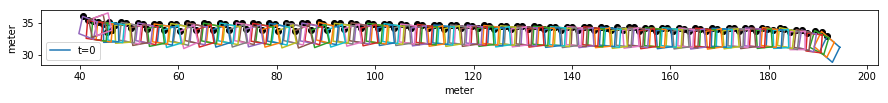

In [158]:
# plot 
Yre = np.array(Y1re[['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
D = Yre
fig, ax = plt.subplots(figsize=(15,1))

for i in range(len(D)):
    coord = D[i,:]
    coord = np.reshape(coord,(-1,2)).tolist()
    coord.append(coord[0]) #repeat the first point to create a 'closed loop'
    xs, ys = zip(*coord) #lon, lat as x, y
    plt.plot(xs,ys,label='t=0' if i==0 else '')

plt.scatter(D[:,2],D[:,3],color='black')

ax = plt.gca()
plt.xlabel('meter')
plt.ylabel('meter')
plt.legend()
ax.format_coord = lambda x,y: '%.6f, %.6f' % (x,y)
plt.show() 

In [60]:
import utils_optimization as opt
importlib.reload(opt)
import utils
importlib.reload(utils)
# optimization parameters
lam1 = 1 # modification of measurement
lam2 = 1 # acceleration
lam3 = 0 # jerk
lam4 = 10 # theta
lam5 = 1 # omega
ID = 22261 
Y1 = groups.get_group(ID)
print(len(Y1))
print(Y1['bbr_x'])
timestamps = Y1['Timestamp'].values
# nans, x= utils.nan_helper_orig(timestamps)
# timestamps[nans]= np.interp(x(nans), x(~nans), timestamps[~nans])
timestamps= utils.nan_helper(timestamps)
dt = np.diff(timestamps)
print(dt)
# get bottom 4 points coordinates
Y1gps = np.array(Y1[['bbrlat','bbrlon','fbrlat','fbrlon','fbllat','fbllon','bbllat','bbllon']])
Y1 = np.array(Y1[['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])

# Euler forward dynamics
start = time.time()
N = len(Y1) 
notNan = ~np.isnan(np.sum(Y1,axis=-1))
Y1 = Y1[notNan,:]
a0 = np.zeros((N))
theta0 = np.zeros((N))
v0 = (Y1[-1,0]-Y1[0,0])/(timestamps[notNan][-1]-timestamps[notNan][0])
x0 = (Y1[0,0]+Y1[0,6])/2
y0 = (Y1[0,1]+Y1[0,7])/2
X0 = np.concatenate((a0.T, theta0.T, \
                     [v0,x0,y0,np.nanmean(np.abs(Y1[:,1]-Y1[:,7])),\
                      np.nanmean(np.abs(Y1[:,0]-Y1[:,2]))]),axis=-1)
bnds = [(-5,5) for i in range(0,N)]+\
    [(-np.pi/8,np.pi/8) for i in range(N)]+\
    [(0,40),(-np.inf,np.inf),(0,np.inf),(1,4),(2,np.inf)]

# Constraints definition (only for COBYLA, SLSQP and trust-constr)
res = minimize(opt.obj1, X0, (Y1,N,dt,notNan,lam1,lam2,lam3,lam4,lam5), method = 'L-BFGS-B',
                bounds=bnds, options={'disp': False,'maxiter':100000})#
end = time.time()
# extract results
Yre, x,y,v,a,theta,omega,w,l = opt.unpack1(res,N,dt)
print('ID:',ID, 'N:',N, 'runtime:',end - start,'\n width:',w,'length:',l)


119
7             NaN
15            NaN
23            NaN
31            NaN
38     169.719018
          ...    
926           NaN
936           NaN
946           NaN
956           NaN
966           NaN
Name: bbr_x, Length: 119, dtype: float64
[0.03700733 0.03336787 0.03336787 0.03336787 0.03336787 0.03336811
 0.03336787 0.03278518 0.03395057 0.03336787 0.03336787 0.03336787
 0.03336787 0.03336787 0.03336787 0.03584218 0.0308938  0.02910614
 0.03999996 0.02999997 0.03000021 0.03999996 0.02999997 0.02999997
 0.03999996 0.02999997 0.02999997 0.0400002  0.02999997 0.02999997
 0.03999996 0.02999997 0.02999997 0.03999996 0.02999997 0.03000021
 0.03999996 0.02999997 0.03999996 0.02999997 0.02999997 0.03999996
 0.03000021 0.02999997 0.03999996 0.02999997 0.02999997 0.03999996
 0.02999997 0.02999997 0.0400002  0.02999997 0.02999997 0.03999996
 0.02999997 0.02999997 0.03999996 0.03000021 0.02999997 0.03999996
 0.02999997 0.02999997 0.03999996 0.02999997 0.02999997 0.0400002
 0.02999997 0.0299999

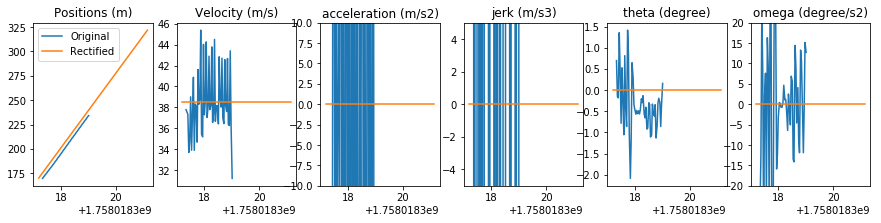

In [59]:
import utils
importlib.reload(utils)
# cx = (Y1[:,0]+Y1[:,6])/2
# cy = (Y1[:,1]+Y1[:,7])/2

fig, (ax1, ax2, ax3, ax4, ax5,ax6) = plt.subplots(1, 6, figsize=(15,3))

ax1.plot(timestamps[notNan], Y1[:,0], label='Original')
ax1.plot(timestamps, Yre[:,0] , label='Rectified')
ax1.legend()
ax1.set_title('Positions (m)')
    
_,_,v1 = utils.calc_vel(Y1, timestamps[notNan])
# _,_,vre = utils.calc_vel(Yre,timestamps)
# v1 = np.diff(Y1[:,0], append=Y1[-1,0])
# vre = np.diff(Yre[:,0], append=Yre[-1,0])
ax2.plot(timestamps[notNan], v1, label='Original velocity')
ax2.plot(timestamps, v , label='Rectified velocity')
ax2.set_title('Velocity (m/s)')

a1 = utils.calc_accel(Y1[:,0], timestamps[notNan])
# are = utils.calc_accel(Yre[:,0],timestamps)
# a1 = np.diff(v1, append=v1[-1])
# are = np.diff(vre, append=vre[-1])
ax3.plot(timestamps[notNan], a1, label='Original accel')
ax3.plot(timestamps, a , label='Rectified accel')
ax3.set_title('acceleration (m/s2)')
ax3.set_ylim([-10,10])

# j1 = np.diff(a1, append=a1[-1])
# jre = np.diff(are, append=are[-1])
j1 = np.gradient(a1,timestamps[notNan])
jre = np.gradient(a, timestamps)
ax4.plot(timestamps[notNan], j1)
ax4.plot(timestamps, jre)
ax4.set_title('jerk (m/s3)')
ax4.set_ylim([-5,5])

theta1 = utils.calc_theta(Y1, timestamps[notNan])
# thetare = utils.calc_theta(Yre,timestamps)
ax5.plot(timestamps[notNan], np.degrees(theta1))
ax5.plot(timestamps, np.degrees(theta))
ax5.set_title('theta (degree)')

thetaddot1 = np.gradient(theta1,timestamps[notNan])
# thetaddotre = np.gradient(np.gradient(thetare)/dt)/dt
# theta1 = np.diff(a1, append=a1[-1])
# jre = np.diff(are, append=are[-1])
ax6.plot(timestamps[notNan], np.degrees(thetaddot1))
ax6.plot(timestamps, np.degrees(omega))
ax6.set_title('omega (degree/s2)')
ax6.set_ylim([-20,20])
plt.show()

In [7]:
# least squares formulation just about the same run time and results
# try calculating the gradient of objective function
# optimize on the road plane
# a formulation that accounts for heading change (for lane changing)
# try having simplified decision variables and no constraints


start = time.time()


p_dim = 2  # lp norm
p = 1

dt = np.gradient(timestamps)
lam1 = 1
lam2 = 0 # regularize acceleration 100
lam3 = 10 # regularize jerk
lam4 = 100 # regularize on thetaddot
lam5 = 100
N = len(Y1)
global lam1, lam2, lam3, lam4, dt, Y1, timestamps, N

def obj(X):
    """The cost function
        X = [cx, cy, theta, w, l]^T
    """    
    cx = X[:N]
    cy = X[N:2*N]
    theta = X[2*N:3*N]
    w = X[3*N]
    l = X[3*N+1]
    
    # compute positions
    xa = cx + w/2*sin(theta)
    ya = cy - w/2*cos(theta)
    xb = xa + l*cos(theta)
    yb = ya + l*sin(theta)
    xc = xb - w*sin(theta)
    yc = yb + w*cos(theta)
    xd = xa - w*sin(theta)
    yd = ya + w*cos(theta)
    Yre = np.stack([xa,ya,xb,yb,xc,yc,xd,yd],axis=-1) 
    
    # min perturbation
    c1 = lam1*np.sum((Y1-Yre)**2)
    
#     # jerk regularization
#     v = np.gradient(cx,timestamps)/cos(theta)
#     a = np.gradient(v,timestamps)
#     j = np.gradient(a,timestamps)
#     c3 = lam3 * np.sum(j**2)

#     # theta ddot regularization
#     thetaddot = np.gradient(np.gradient(theta)/dt)/dt
#     c4 = lam4 * np.sum(thetaddot**2)
# #     print(c1,c3,c4)

#     # pfaffian constraint
#     vx = np.gradient(cx)/dt
#     vy = np.gradient(cy)/dt
#     c5 = lam5*np.sum((-vx*sin(theta)+vy*cos(theta))**2)
#     print(c1,c3,c4,c5)
    return c1 

def const5(X):
    # Pfaffian constraint
    cx = X[:N]
    cy = X[N:2*N]
    theta = X[2*N:3*N]

    vx = np.gradient(cx)/dt
    vy = np.gradient(cy)/dt
    return -vx*sin(theta)+vy*cos(theta)
    
#     return np.sum(c5**2)
nlc = ({"type": "eq", "fun": const5})
# initial values
cx0 = (Y1[:,0]+Y1[:,6])/2
cy0 = (Y1[:,1]+Y1[:,7])/2
w0 = 1
l0 = 4
theta0 = np.zeros((N))
X0 = np.concatenate((cx0.T, cy0.T, theta0, [w0,l0]), axis=0)
bnds = [(0,np.inf) for i in range(0,2*N)]+[(-np.pi/8,np.pi/8) for i in range(len(theta0))]+[(1,4),(2,50)]
list1, list2 = zip(*bnds)
bnd_list = (list(list1),list(list2))

# Constraints definition (only for COBYLA, SLSQP and trust-constr)
res = minimize(obj, X0, method = 'L-BFGS-B',
                bounds=bnds, options={'disp': False,'maxiter':100000})#
# BFGS: fast,ok
# L-BFGS-B: really fast, ok results
# CG: slow, ok
# COBLYA: fast but results no good
# SLSQP and fmin_slsqp: inequality cosntraints incompatible
# res = fmin_slsqp(obj, X0, # inequality constraint not compatible
#                 bounds=bnds, disp= True, iter=1000)
# res = least_squares(obj, X0, # super slow
#                 bounds=bnd_list, verbose = 2)
# res = shgo(obj,bounds=bnds)
end = time.time()
print(end - start)
# extract results
cx = res.x[:N]
cy = res.x[N:2*N]
theta = res.x[2*N:3*N]
w = res.x[3*N]
l = res.x[3*N+1]

Yre = utils.calc_positions(cx,cy,theta,w,l)
print(w,l)

0.3485264778137207
1.3014620637148426 4.276270081179986


In [76]:
# optimize on the road plane
# a formulation that accounts for heading change (for lane changing)
import time
start = time.time()
from scipy.optimize import minimize,NonlinearConstraint,leastsq,fmin_slsqp
import numpy.linalg as LA
p_dim = 2  # lp norm
p = 1
lam1 = 1000
lam2 = 100 # regularize acceleration
lam3 = 2 # regularize jerk
lam4 = 10 # regularize on thetaddot
N = len(Y1)
global lam1, lam2, lam3, lam4, dt, Y1, timestamps, N

def obj(X):
    """The cost function"""    
    X_data = X[:8*N]
    w = X[8*N]
    l = X[8*N+1]

    Yre = X_data.reshape(N, -1)
    Yre = np.reshape(X_data,(-1,N)).T
    theta = X[8*N+2:]
    
    # calculate cs, cy
    cx = (Yre[:,0]+Yre[:,6])/2
    cy = (Yre[:,1]+Yre[:,7])/2
    
    # min perturbation
    c1 = lam1*LA.norm(Y1-Yre,2)
    
    # acceleration regularization
    dx = np.gradient(cx)
    vx = dx/dt
    dy = np.gradient(cy)
    vy = dy/dt
    v = np.sqrt(vx**2+vy**2)
    
    a = np.gradient(v)/dt
    c2 = lam2 * LA.norm(a,2)
    
    # jerk regularization
    j = np.gradient(a)/dt
    c3 = lam3 * LA.norm(j,2)

    # theta ddot regularization
    thetaddot = np.gradient(np.gradient(theta)/dt)/dt
    c4 = lam4 * LA.norm(thetaddot,2)
#     print(c1,c2,c3,c4)
    return c1 + c2 + c3 +c4

def const4(X):
    # rectangle shape constraint using theta
    X_data = X[:8*N]
    w = X[8*N]
    l = X[8*N+1]
    Yre = X_data.reshape(N, -1)
    Yre = np.reshape(X_data,(-1,N)).T
    theta = X[8*N+2:]
#     theta = utils.calc_theta(Yre, timestamps)
    
    cx = (Yre[:,0]+Yre[:,6])/2
    cy = (Yre[:,1]+Yre[:,7])/2

    sos = np.sum((cx + w/2*sin(theta) - Yre[:,0])**2)\
        + np.sum((cy - w/2*cos(theta) - Yre[:,1])**2)\
        + np.sum((Yre[:,0]+l*cos(theta)-Yre[:,2])**2)\
        + np.sum((Yre[:,1]+l*sin(theta)-Yre[:,3])**2)\
        + np.sum((Yre[:,2]-w*sin(theta)-Yre[:,4])**2)\
        + np.sum((Yre[:,3]+w*cos(theta)-Yre[:,5])**2)\
        + np.sum((Yre[:,0]-w*sin(theta)-Yre[:,6])**2)\
        + np.sum((Yre[:,1]+w*cos(theta)-Yre[:,7])**2)
    return sos
#     return 0.0001-sos

def const5(X):
    # Pfaffian constraint
    X_data = X[:8*N]
    w = X[8*N]
    l = X[8*N+1]
    Yre = X_data.reshape(N, -1)
    Yre = np.reshape(X_data,(-1,N)).T
    theta = X[8*N+2:]
#     theta = utils.calc_theta(Yre, timestamps)
    # calculate cs, cy
    cx = (Yre[:,0]+Yre[:,6])/2
    cy = (Yre[:,1]+Yre[:,7])/2

    dx = np.gradient(cx)
    vx = dx/dt
    dy = np.gradient(cy)
    vy = dy/dt
    c5 = -vx*sin(theta)+vy*cos(theta)
    return np.sum(c5**2)
#     return 0.001-np.sum(c5**2)

nlc = ({"type": "eq", "fun": const4},
      {"type": "eq", "fun": const5})

Y1f = Y1.flatten('F')
theta0 = np.zeros((N))
X0 = np.concatenate((Y1f, [1.1, 3],theta0), axis=0)
bnds = [(0,np.inf) for i in range(0,8*N)]+[(1,4),(2,50)]+[(-np.pi/8,np.pi/8) for i in range(len(theta0))]

res = minimize(obj, X0, method = 'SLSQP',
                constraints=nlc,
                bounds=bnds, options={'disp': True, 'maxiter':1000})

end = time.time()
print(end - start)

X_data = res.x[:8*N]
w = res.x[8*N]
l = res.x[8*N+1]
theta = res.x[8*N+2:]
#     theta = X[8*N+2:]
Yre = np.reshape(X_data,(-1,N)).T
# theta = utils.calc_theta(Yre, timestamps)
print(w,l)


TypeError: 'dict' object is not callable

In [84]:
# ver1: slow but accurate
# optimize on the road plane
# returns sigular matrix (constraints not continuous) if using equality constraints
import time

start = time.time()
from scipy.optimize import minimize,NonlinearConstraint
import numpy.linalg as LA
p_dim = 2  # lp norm
p = 1


lam = 0.001 # regularize acceleration
lam2 = 0.0001 # regularize jerk
global lam, lam2, dt, Y1, timestamps

def obj(X):
    """The cost function"""   
#     global Yre, w, l
    X_data = X[:-2]
    w = X[-2]
    l = X[-1]
    Yre = X_data.reshape(len(Y1), -1)
    Yre = np.reshape(X_data,(-1,len(Y1))).T
#     
    # min perturbation
    c1 = LA.norm(Y1-Yre,2)

    # acceleration regularization
    dx = np.gradient(Yre[:,0])
    v = dx/dt
    a = np.gradient(v)/dt
    c2 = lam * LA.norm(a,2)
    
    # jerk regularization
    j = np.gradient(a)/dt
    c3 = lam2 * LA.norm(j,2)
    return c1 + c2 + c3

def const1(X):
    # l, l, w, w, squared
    X_data = X[:-2]
    w = X[-2]
    l = X[-1]
    Yre = X_data.reshape(len(Y1), -1)
    Yre = np.reshape(X_data,(-1,len(Y1))).T
    return 0.0001-np.sum((Yre[:,[2,4,3,1]]-Yre[:,[0,6,5,7]]-np.array([l,l,w,w]))**2)
#     return (Yre[:,[2,4,3,1]]-Yre[:,[0,6,5,7]]-np.array([l,l,w,w]))**2
          
def const2(X):
    # rectangle shape constraint
    X_data = X[:-2]
    w = X[-2]
    l = X[-1]
    Yre = X_data.reshape(len(Y1), -1)
    Yre = np.reshape(X_data,(-1,len(Y1))).T
    return 0.0001-np.sum((Yre[:,[1,7,2,0]]-Yre[:,[3,5,4,6]])**2)
#     return (Yre[:,[1,7,2,0]]-Yre[:,[3,5,4,6]]).flatten('F')
                  
def const3(X):
    # follow straight lines movement and widthes are parallel to lanes
    X_data = X[:-2]
    w = X[-2]
    l = X[-1]
    Yre = X_data.reshape(len(Y1), -1)
    Yre = np.reshape(X_data,(-1,len(Y1))).T
    return 0.1 - np.std(Yre[:,3]) - np.std(Yre[:,1]) - np.std(Yre[:,5]) - np.std(Yre[:,7])
#     return np.std(Yre[:,3]) + np.std(Yre[:,1]) + np.std(Yre[:,5]) + np.std(Yre[:,7])


nlc = ({"type": "ineq", "fun": const1},
       {"type": "ineq", "fun": const2},
       {"type": "ineq", "fun": const3})
Y1f = Y1.flatten('F')
X0 = np.append(Y1f,[2.2, 4])
bnds = [(0,np.inf) for i in range(0,len(X0)-2)]+[(1,3),(2,np.inf)]

res = minimize(obj, X0, method='SLSQP', 
               constraints=nlc,
               bounds=bnds, options={'disp': True, 'maxiter':1000})
end = time.time()
print(end - start)

X_data = res.x[:-2]
w = res.x[-2]
l = res.x[-1]
Yre = np.reshape(X_data,(-1,len(Y1))).T

print(w,l)


Iteration limit exceeded    (Exit mode 9)
            Current function value: 13.814819920458618
            Iterations: 1001
            Function evaluations: 290232
            Gradient evaluations: 998
104.13162207603455
1.000000000000086 4.313711616444018


In [22]:
lat1, lon1 = A
lat2, lon2 = B
pt = 'bbl'
pt_lats = np.array(Y1[[pt+'lat']])
pt_lons = np.array(Y1[[pt+'lon']])
toA = utils.haversine_distance(lat1, lon1, pt_lats, pt_lons)
toAB = utils.pt_to_line_dist_gps(lat1, lon1, lat2, lon2, pt_lats, pt_lons)
x = np.sqrt(toA**2-toAB**2)

In [ ]:
# histogram of distance _y
n, bins, patches = plt.hist(x=Yre[:,2]-Yre[:,0], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
# plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [ ]:
# one-step ahead prediction from Y2 using vx and vy
def one_step_predict(Y, vx, vy, fps):
    Y2pred = Y.copy()
    Y2pred[:,[0,2,4,6]] = Y[:,[0,2,4,6]] + vx*1/fps
    Y2pred[:,[1,3,5,7]] = Y[:,[1,3,5,7]] + vy*1/fps
    return Y2pred

In [ ]:
# in lat/long per second
vx = (Y1.loc[Y1.index[-1]].bbrlat - Y1.loc[Y1.index[0]].bbrlat)/(Y1.loc[Y1.index[-1]].Timestamp - Y1.loc[Y1.index[0]].Timestamp)
vy = (Y1.loc[Y1.index[-1]].bbrlon - Y1.loc[Y1.index[0]].bbrlon)/(Y1.loc[Y1.index[-1]].Timestamp - Y1.loc[Y1.index[0]].Timestamp)
print(vx, vy)
Y3pred = one_step_predict(Y3, vx, vy, fps)

In [73]:
import utils
importlib.reload(utils)
AB = np.array([A,B])
lats = AB[:,0]
lngs = AB[:,1]
# print(utils.euclidean_distance(lats[0],lngs[0],lats[1],lngs[1]))
# print(utils.haversine_distance(lats[0],lngs[0],lats[1],lngs[1]))
utils.euclidean_distance(lats[0],lngs[0],Y1gps[:,0],Y1gps[:,1])

array([166.02834251, 167.21634731, 168.34819208, 169.6669836 ,
       170.77034016, 172.05936981, 173.27084343, 174.54504232,
       175.56284385, 176.88665959, 178.18531685, 179.32701601,
       180.6368458 , 181.84680672, 182.97507077, 184.37600768,
       185.49557427, 186.75461827, 192.83733281, 189.35870389,
       190.67234252, 192.04682815, 193.20266908, 194.50830515,
       195.83242475, 197.12840302, 198.51846321, 199.77310761,
       201.07637787, 202.40417507, 203.68813749, 205.0330999 ,
       206.33208362, 207.65670457, 208.88900684, 210.26975751,
       211.54065824, 212.8434962 , 214.2254466 , 215.50640658,
       216.76787543, 218.07329433, 219.46692237, 220.72960725,
       222.0342831 , 223.30060811, 224.57247823, 225.85950811,
       227.24299395, 228.47206544, 229.78535018, 231.00526153,
       232.3263121 , 233.62059252, 234.88210281,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,       

(51, 8)

In [85]:
Y1gps

(119, 8)